# Stage 1 analysis; Long wavelength Spectroscopy

In [1]:
import sys, os, time                                                            
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits

from importlib import reload                                                    
import eureka.S1_detector_processing.s1_process as s1                                 
from eureka.lib import readECF as rd                                            
from eureka.lib import logedit                                                  
from eureka.lib import readECF as rd                                            
from eureka.lib import manageevent as me                                        
#from eureka.S1_data_reduction import optspex                                    
from eureka.lib import astropytable                                             
from eureka.lib import util   

plt.rcParams['font.size'] = 15
plt.rcParams['lines.markersize'] = 2

In [2]:
# Starts timer to monitor how long data reduction takes
t0      = time.time()

# Names the event (has to match the event name used for the *.ecf files)
eventlabel = 'wasp39b'                                                           

In [3]:
!ls 'dc-roof'

jwdata0010010_11010_0001_NRS1_uncal_updatedHDR_10INTS.fits
jwdata0010010_11010_0001_NRS1_uncal_updatedHDR_10INTS_ramp.fits
jwdata0010010_11010_0001_NRS1_uncal_updatedHDR_10INTS_ramp_SKIPJUMP.fits
jwdata0010010_11010_0001_NRS1_uncal_updatedHDR_10INTS_ramp_STOPAFTERBIAS.fits
jwdata0010010_11010_0001_NRS1_uncal_updatedHDR_10INTS_ramp_STOPAFTERBIAS_add_lin_corr.fits


In [4]:
hdul = fits.open("dc-roof/jwdata0010010_11010_0001_NRS1_uncal_updatedHDR_10INTS_ramp_STOPAFTERBIAS.fits")
hdul.info()

Filename: dc-roof/jwdata0010010_11010_0001_NRS1_uncal_updatedHDR_10INTS_ramp_STOPAFTERBIAS.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     209   ()      
  1  SCI           1 ImageHDU        50   (512, 32, 3, 10)   float32   
  2  PIXELDQ       1 ImageHDU        11   (512, 32)   int32 (rescales to uint32)   
  3  GROUPDQ       1 ImageHDU        11   (512, 32, 3, 10)   uint8   
  4  ERR           1 ImageHDU        11   (512, 32, 3, 10)   float32   
  5  ASDF          1 BinTableHDU     11   1R x 1C   [6414B]   


In [5]:
hdul[1].data

array([[[[ 4.80777588e+01,  7.61723633e+01,  7.25468750e+01, ...,
           6.44921875e+01,  6.65727539e+01,  1.22924805e+01],
         [ 9.70588379e+01,  5.52854004e+01,  7.47080078e+01, ...,
           4.26142578e+01,  4.30212402e+01,  8.54492188e-02],
         [ 1.02121826e+02,  1.10812256e+02,  1.18520508e+01, ...,
           9.89152832e+01,  2.12121582e+01,  4.37231445e+00],
         ...,
         [ 6.59252930e+01,  1.04605469e+02,  9.32697754e+01, ...,
           5.57208252e+01,  3.89252930e+01,  2.68052979e+01],
         [ 9.85385742e+01,  6.63381348e+01,  1.32535034e+02, ...,
           8.52294922e-01,  6.94245605e+01, -8.81164551e-01],
         [ 4.89370117e+01, -3.92187500e+00,  2.80454102e+01, ...,
           1.01806641e+01,  7.26525879e+01, -1.01147461e+01]],

        [[ 2.20777588e+01,  6.41723633e+01,  6.25468750e+01, ...,
           1.09492188e+02,  8.35727539e+01,  4.32924805e+01],
         [ 7.20588379e+01,  5.32854004e+01,  6.17080078e+01, ...,
           7.06142578e

In [6]:
hdul[0].header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                    8 / array data type                                
NAXIS   =                    0 / number of array dimensions                     
EXTEND  =                    T                                                  
DATE    = '2022-03-21T19:37:31.874' / UTC date file created                     
ORIGIN  = 'STScI   '           / Organization responsible for creating file     
FILENAME= 'jwdata0010010_11010_0001_NRS1_uncal_updatedHDR_10INTS_ramp.fits' / Na
FILETYPE= 'countrate'          / Type of data in the file                       
SDP_VER = 'B7.0    '           / Data processing software version number        
CAL_VER = '1.3.3   '           / Calibration software version number            
CAL_VCS = 'RELEASE '           / Calibration software version control sys number
DATAMODL= 'RampModel'          / Type of data model                             
TELESCOP= 'JWST    '        

In [7]:
print(np.shape(hdul[1].data[:,:,1,:,]))

np.shape(hdul[1].data[:,:,:,:,])

(10, 3, 512)


(10, 3, 32, 512)

0
1
2
3
4
5
6
7
8
9


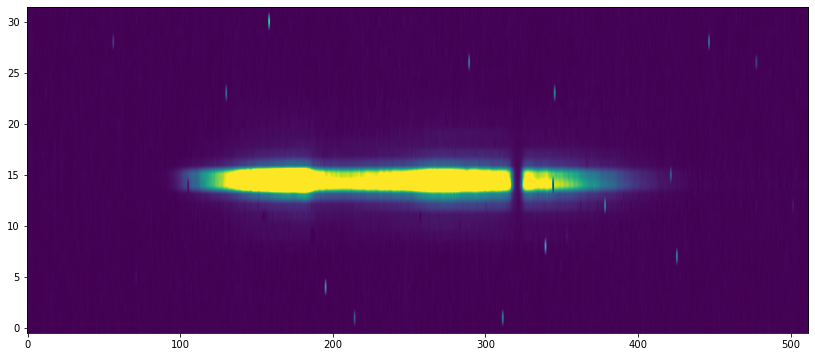

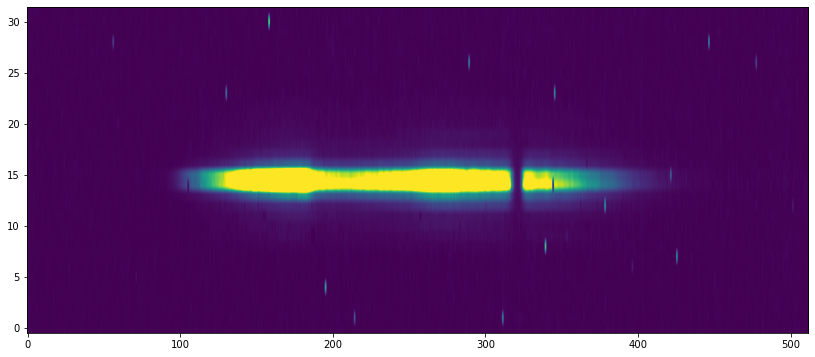

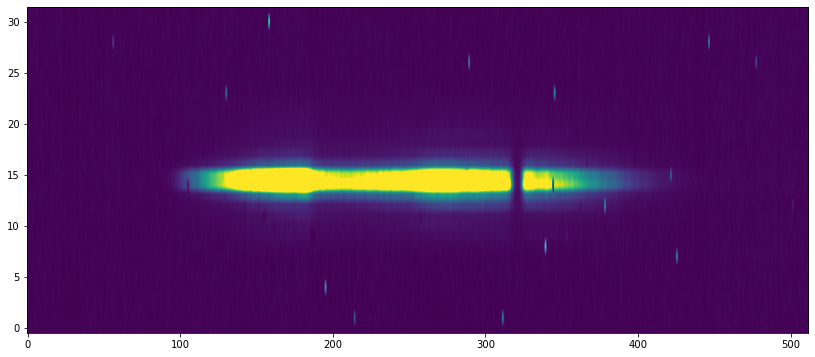

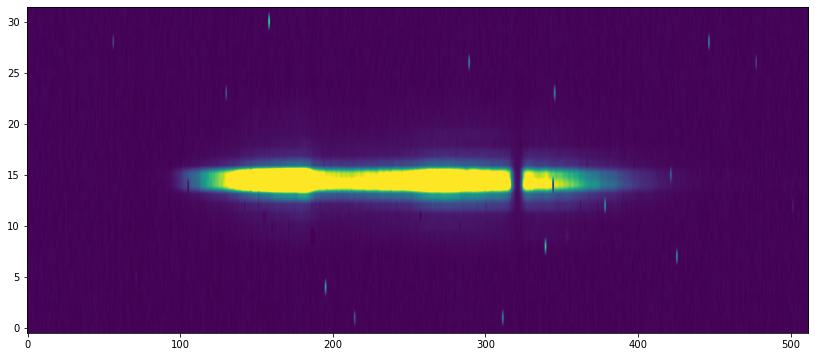

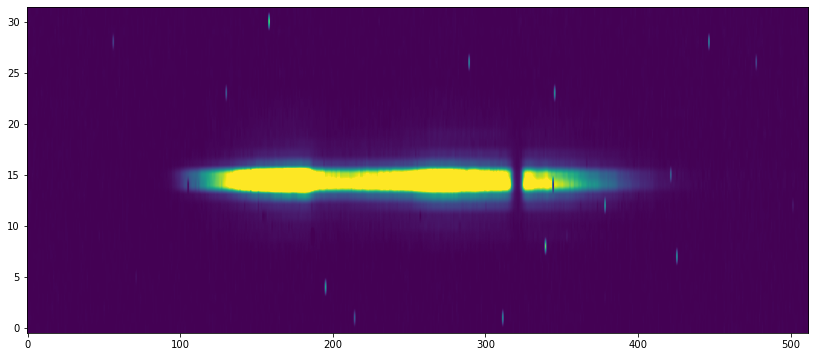

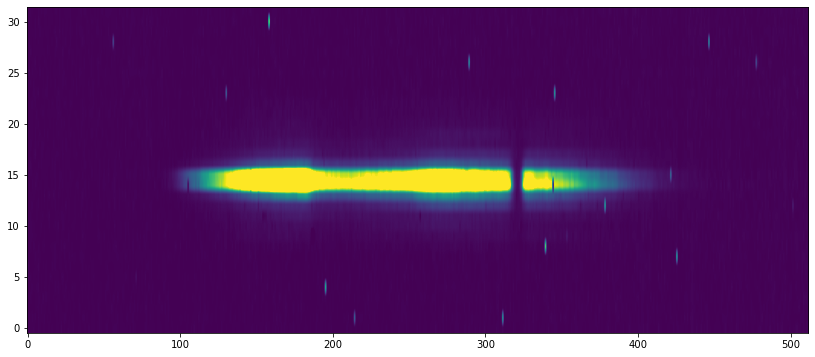

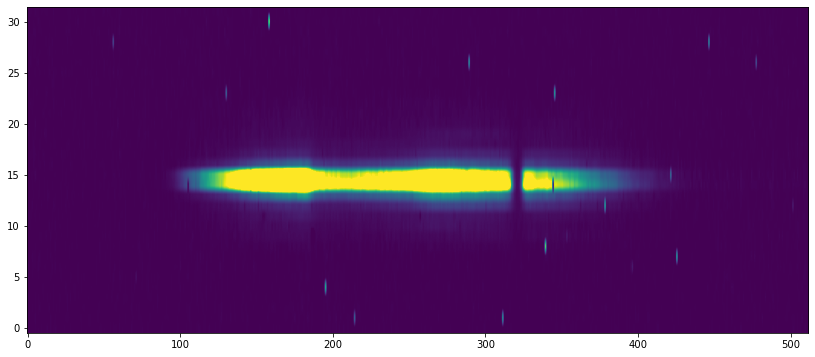

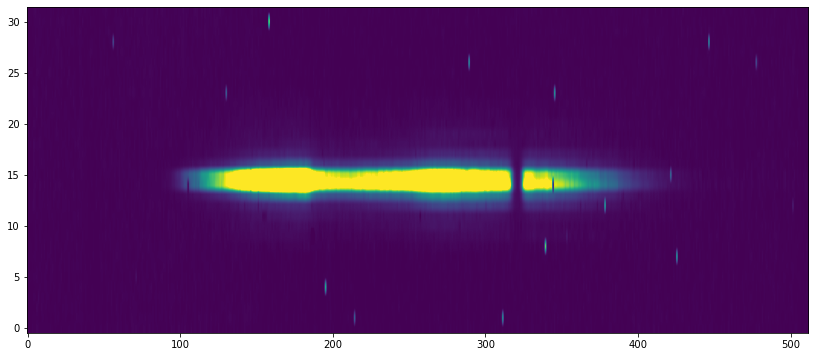

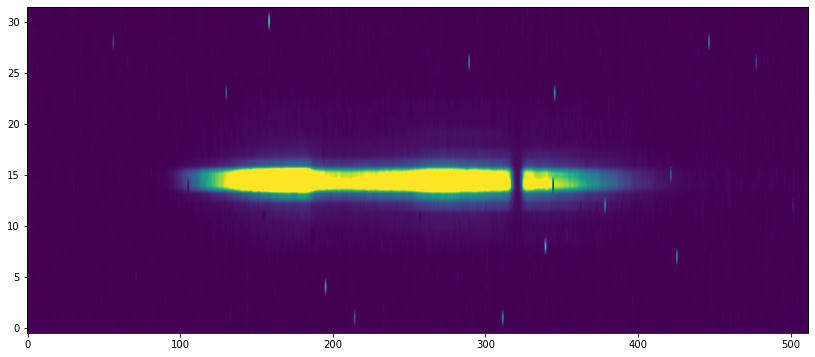

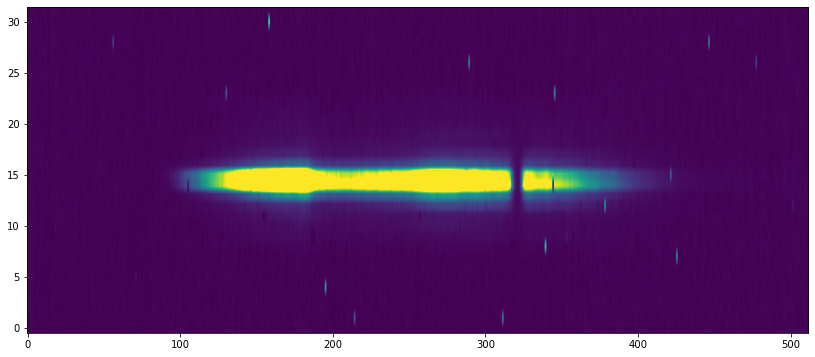

In [8]:
%matplotlib inline
for i in range(0, 10):
    print(i)
    fig, ax = plt.subplots(1, 1, figsize=(14, 6))
    plt.imshow(hdul[1].data[i,1,:,:,], origin = 'lower', aspect='auto',  vmin=0, vmax=1e4)

In [9]:
# Sum the rows and columns for group 0

def row_col_counter(colsize, rowsize, group_num, integr_num):
    col_arrays = []
    col_values = np.zeros(colsize)

    for col_num in range(0, rowsize):
        for row_num in range(0,colsize):
            col_values[row_num] = hdul[1].data[integr_num,group_num,row_num,col_num]
        col_arrays.append(col_values.tolist())

    col_arrays_flat = [item for sublist in col_arrays for item in sublist]
    
    return col_arrays, np.array(col_arrays_flat)


In [10]:
colsize = hdul[0].header['SUBSIZE2']
rowsize = hdul[0].header['SUBSIZE1']

col_arrays0, col_arrays_flat0 = row_col_counter(colsize, rowsize, group_num=0, integr_num=0)
col_arrays1, col_arrays_flat1 = row_col_counter(colsize, rowsize, group_num=0, integr_num=1)
col_arrays2, col_arrays_flat2 = row_col_counter(colsize, rowsize, group_num=0, integr_num=2)
col_arrays3, col_arrays_flat3 = row_col_counter(colsize, rowsize, group_num=0, integr_num=3)
col_arrays4, col_arrays_flat4 = row_col_counter(colsize, rowsize, group_num=0, integr_num=4)
col_arrays5, col_arrays_flat5 = row_col_counter(colsize, rowsize, group_num=0, integr_num=5)
col_arrays6, col_arrays_flat6 = row_col_counter(colsize, rowsize, group_num=0, integr_num=6)
col_arrays7, col_arrays_flat7 = row_col_counter(colsize, rowsize, group_num=0, integr_num=7)
col_arrays8, col_arrays_flat8 = row_col_counter(colsize, rowsize, group_num=0, integr_num=8)
col_arrays9, col_arrays_flat9 = row_col_counter(colsize, rowsize, group_num=0, integr_num=9)

In [11]:
np.shape(hdul[1].data[:,0,:,:])

(10, 32, 512)

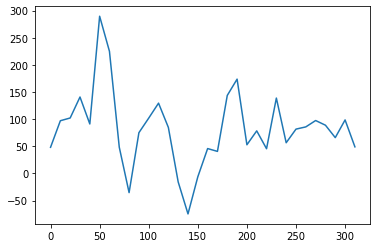

In [12]:
time_np = np.arange(0, 320, 10)
plt.plot(time_np, col_arrays0[0])

In [13]:
time_full = [time_np.copy()]
print(time_full)

for i in np.arange(1,rowsize):
    #print(i)
    #print(time_np.copy()+(120)+time_full[-1][-1])
    time_full.append(time_np.copy()+120+time_full[-1][-1])
    
    
time_full_flat = [item for sublist in time_full for item in sublist]
time_full_flat = np.array(time_full_flat)

[array([  0,  10,  20,  30,  40,  50,  60,  70,  80,  90, 100, 110, 120,
       130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250,
       260, 270, 280, 290, 300, 310])]


<IPython.core.display.Javascript object>


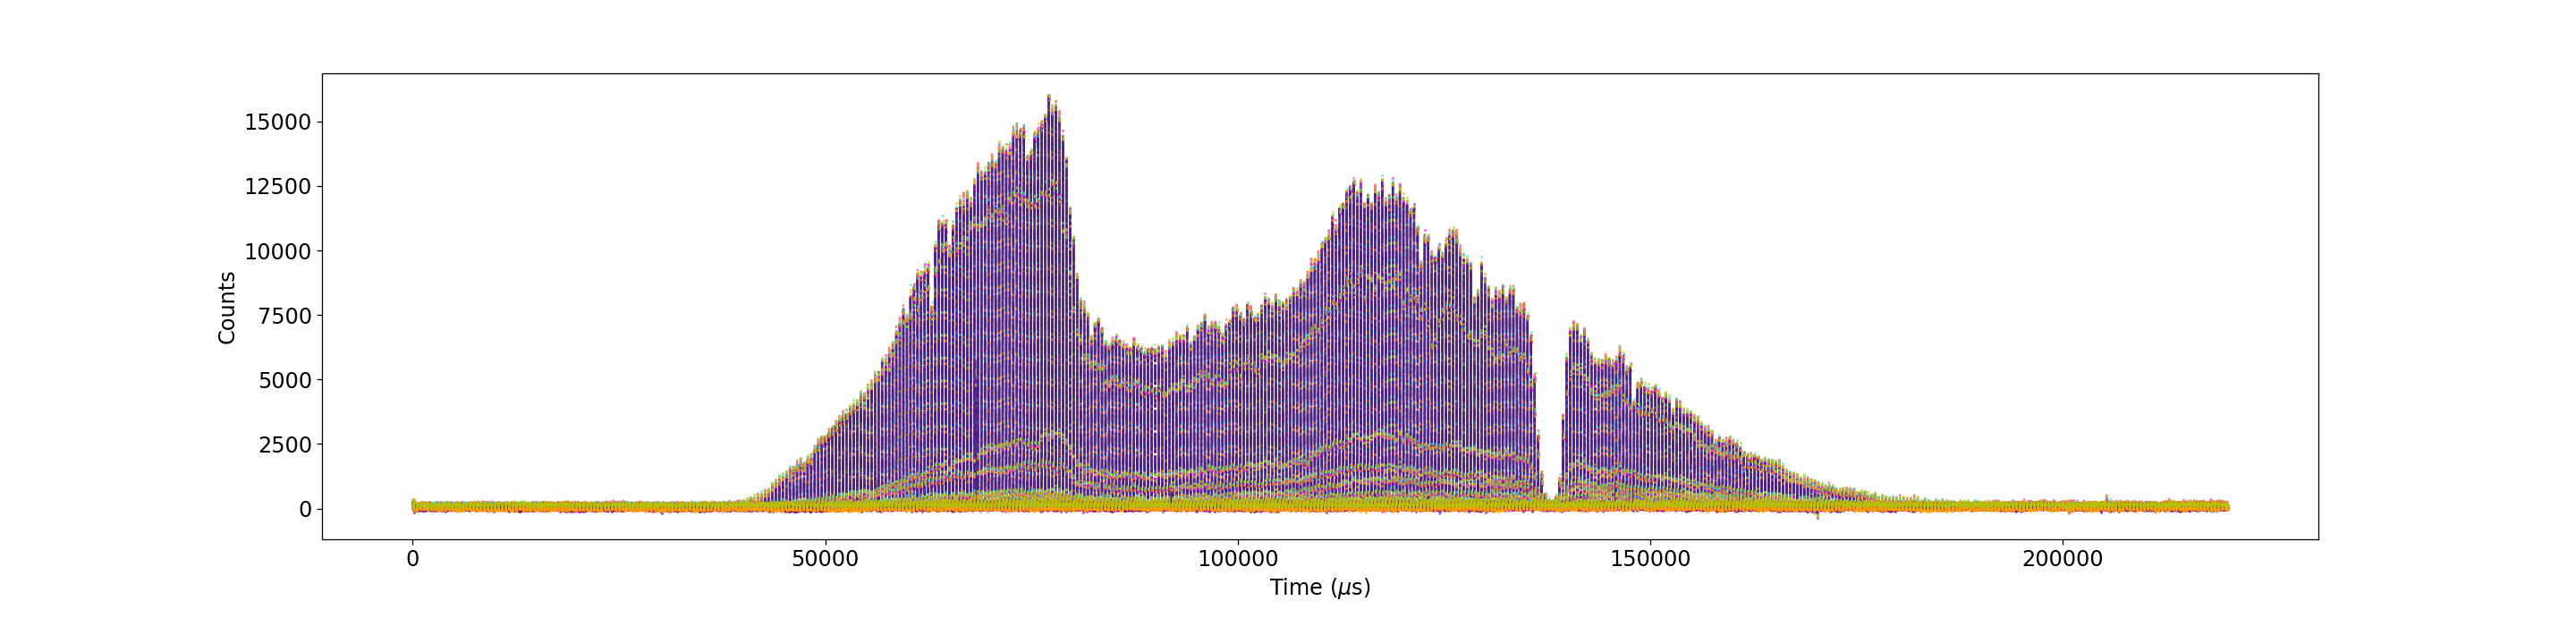

Text(0, 0.5, 'Counts')

In [14]:
# plot the ten different integrations
#%matplotlib inline
%matplotlib notebook
fig, ax = plt.subplots(1, 1, figsize=(25, 6))

for i in np.arange(0, len(col_arrays0)):
    plt.plot(time_full[i], col_arrays0[i], "-.", color='k', alpha=0.5)
    plt.plot(time_full[i], col_arrays1[i], "-.", color='g', alpha=0.5)
    plt.plot(time_full[i], col_arrays2[i], "-.", color='r', alpha=0.5)
    plt.plot(time_full[i], col_arrays3[i], "-.", color='b', alpha=0.5)
    plt.plot(time_full[i], col_arrays4[i], ".", color='purple', alpha=0.5)
    plt.plot(time_full[i], col_arrays5[i], ".", color='lawngreen', alpha=0.5)
    plt.plot(time_full[i], col_arrays6[i], ".", color='fuchsia', alpha=0.5)
    plt.plot(time_full[i], col_arrays7[i], ".", color='turquoise', alpha=0.5)
    plt.plot(time_full[i], col_arrays8[i], ".", color='orange', alpha=0.5)
    plt.plot(time_full[i], col_arrays9[i], ".", color='y', alpha=0.5)
    #plt.xlim(0, 6000)
    #plt.ylim(-50, 400)
    
plt.xlabel("Time ($\mu$s)")
plt.ylabel("Counts")

In [15]:
xmin = 40550
ymin = 180

xmax = 183500
ymax = 16000


def index_mask_finder(col_arrays_flat, ymin):
    indexes_keep = (np.array(col_arrays_flat0)<ymin).nonzero()[0]
    return indexes_keep

def masked_time_col(col_arrays_flat, ymin):
    indexes_keep = (np.array(col_arrays_flat)<ymin).nonzero()[0]
    return time_full_flat[index_mask_finder(col_arrays_flat, ymin)].tolist(), col_arrays_flat[index_mask_finder(col_arrays_flat, ymin)].tolist()


In [16]:
np.where(np.array(col_arrays_flat0)<ymin)

(array([    0,     1,     2, ..., 16381, 16382, 16383]),)

<IPython.core.display.Javascript object>


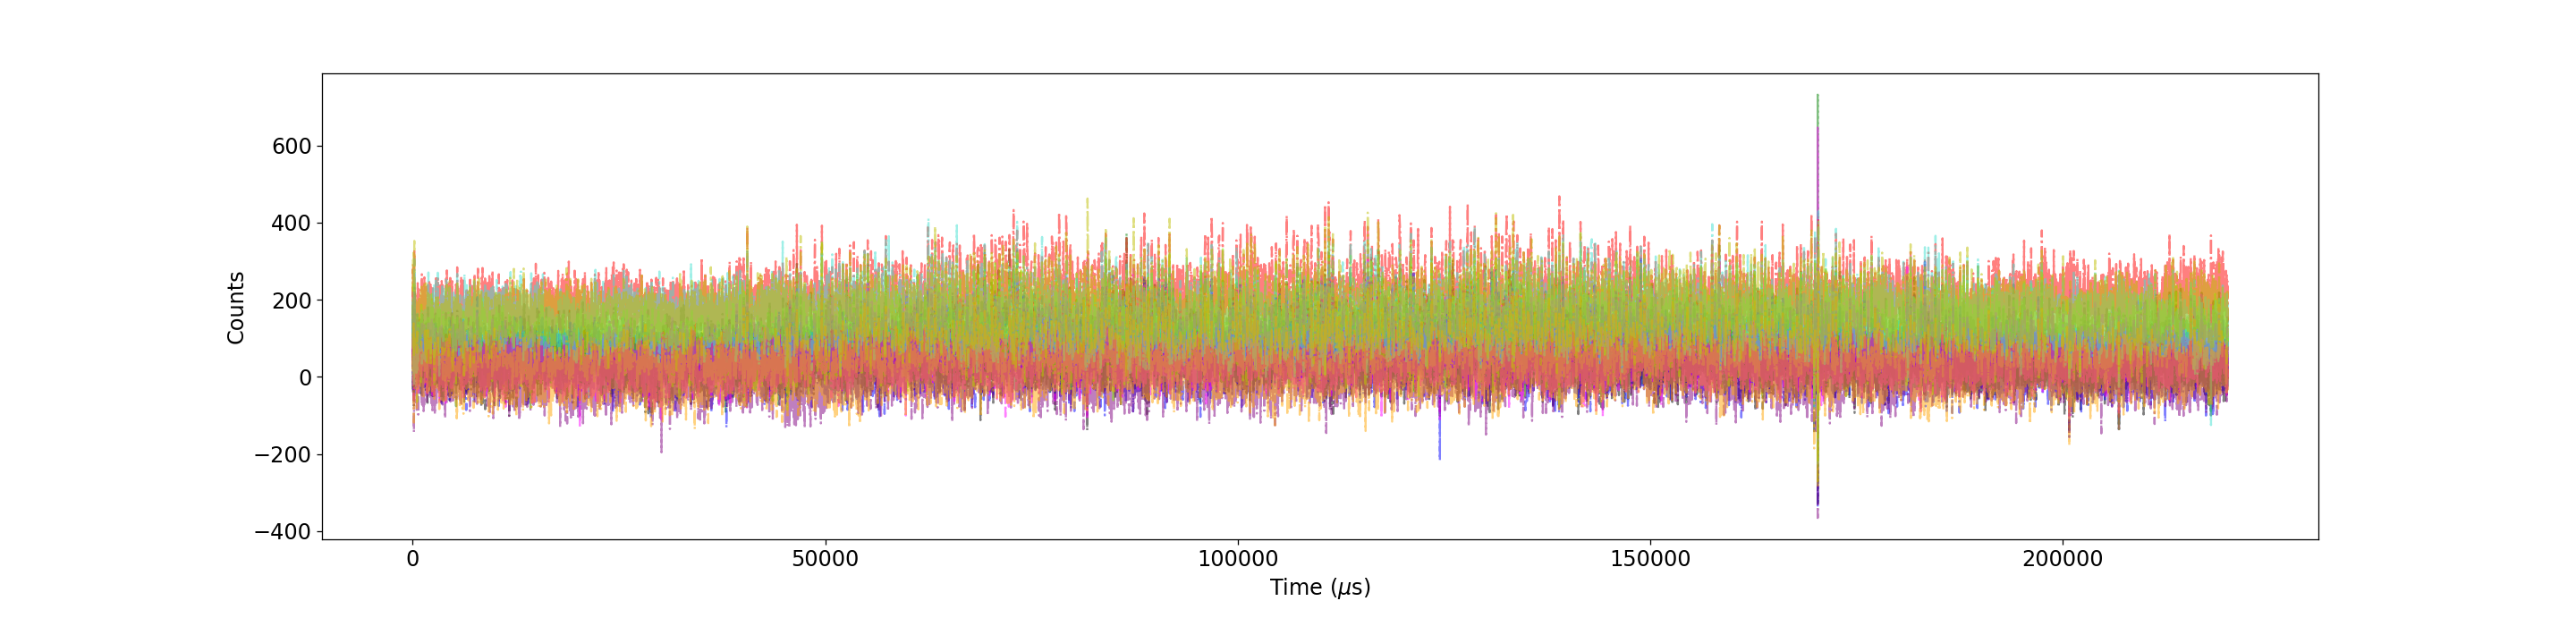

Text(0, 0.5, 'Counts')

In [17]:
%matplotlib notebook
fig, ax = plt.subplots(1, 1, figsize=(25, 6))

plt.plot(time_full_flat[index_mask_finder(col_arrays_flat0, ymin)], 
         col_arrays_flat0[index_mask_finder(col_arrays_flat0, ymin)], "-.", color='k', alpha=0.5)
plt.plot(time_full_flat[index_mask_finder(col_arrays_flat1, ymin)], 
         col_arrays_flat1[index_mask_finder(col_arrays_flat1, ymin)], "-.", color='green', alpha=0.5)
plt.plot(time_full_flat[index_mask_finder(col_arrays_flat2, ymin)], 
         col_arrays_flat2[index_mask_finder(col_arrays_flat2, ymin)], "-.", color='r', alpha=0.5)
plt.plot(time_full_flat[index_mask_finder(col_arrays_flat3, ymin)], 
         col_arrays_flat3[index_mask_finder(col_arrays_flat3, ymin)], "-.", color='b', alpha=0.5)
plt.plot(time_full_flat[index_mask_finder(col_arrays_flat4, ymin)], 
         col_arrays_flat4[index_mask_finder(col_arrays_flat4, ymin)], "-.", color='purple', alpha=0.5)
plt.plot(time_full_flat[index_mask_finder(col_arrays_flat5, ymin)], 
         col_arrays_flat5[index_mask_finder(col_arrays_flat5, ymin)], "-.", color='lawngreen', alpha=0.5)
plt.plot(time_full_flat[index_mask_finder(col_arrays_flat6, ymin)], 
         col_arrays_flat6[index_mask_finder(col_arrays_flat6, ymin)], "-.", color='fuchsia', alpha=0.5)
plt.plot(time_full_flat[index_mask_finder(col_arrays_flat7, ymin)], 
         col_arrays_flat7[index_mask_finder(col_arrays_flat7, ymin)], "-.", color='turquoise', alpha=0.5)
plt.plot(time_full_flat[index_mask_finder(col_arrays_flat8, ymin)], 
         col_arrays_flat8[index_mask_finder(col_arrays_flat8, ymin)], "-.", color='orange', alpha=0.5)
plt.plot(time_full_flat[index_mask_finder(col_arrays_flat9, ymin)], 
         col_arrays_flat9[index_mask_finder(col_arrays_flat9, ymin)], "-.", color='y', alpha=0.5)
#plt.xlim(0, 6000)
#plt.ylim(-50, 400)
    
plt.xlabel("Time ($\mu$s)")
plt.ylabel("Counts")

## extract masked times and column counts

In [18]:
masked_time0, maskedcol_arrays0 = masked_time_col(col_arrays_flat0, ymin)
masked_time1, maskedcol_arrays1 = masked_time_col(col_arrays_flat1, ymin)
masked_time2, maskedcol_arrays2 = masked_time_col(col_arrays_flat2, ymin)
masked_time3, maskedcol_arrays3 = masked_time_col(col_arrays_flat3, ymin)
masked_time4, maskedcol_arrays4 = masked_time_col(col_arrays_flat4, ymin)
masked_time5, maskedcol_arrays5 = masked_time_col(col_arrays_flat5, ymin)
masked_time6, maskedcol_arrays6 = masked_time_col(col_arrays_flat6, ymin)
masked_time7, maskedcol_arrays7 = masked_time_col(col_arrays_flat7, ymin)
masked_time8, maskedcol_arrays8 = masked_time_col(col_arrays_flat8, ymin)
masked_time9, maskedcol_arrays9 = masked_time_col(col_arrays_flat9, ymin)

all_masked_times = np.array([masked_time0, masked_time1, masked_time2, masked_time3, masked_time4, masked_time5,
                            masked_time6, masked_time7, masked_time8, masked_time9])
all_masked_cols = np.array([maskedcol_arrays0, maskedcol_arrays1, maskedcol_arrays2, maskedcol_arrays3, maskedcol_arrays4,
                            maskedcol_arrays5, maskedcol_arrays6, maskedcol_arrays7, maskedcol_arrays8, maskedcol_arrays9])
    

## Periodogram

In [19]:
%matplotlib inline
# import packages
from astropy.timeseries import LombScargle
from astropy.timeseries import TimeSeries
from astropy.table import Table
from astropy.time import Time
import astropy.units as u

min freq: 4.544628249409198e-07 max freq: 0.16088029449191055
best period: 242560.18818745986
min freq: 4.544628249409198e-07 max freq: 0.16088029449191055
best period: 270401.8472213569
min freq: 4.544628249409198e-07 max freq: 0.16088029449191055
best period: 2200400.0
min freq: 4.544628249409198e-07 max freq: 0.16088029449191055
best period: 148277.7462362844
min freq: 4.544628249409198e-07 max freq: 0.16088029449191055
best period: 270401.8472213569
min freq: 4.544628249409198e-07 max freq: 0.16088029449191055
best period: 317253.85564045893
min freq: 4.544628249409198e-07 max freq: 0.16088029449191055
best period: 430.4397228413062
min freq: 4.544628249409198e-07 max freq: 0.16088029449191055
best period: 115562.3218264982
min freq: 4.544628249409198e-07 max freq: 0.16088029449191055
best period: 107.53359669201251
min freq: 4.544628249409198e-07 max freq: 0.16088029449191055
best period: 502656.15229295177


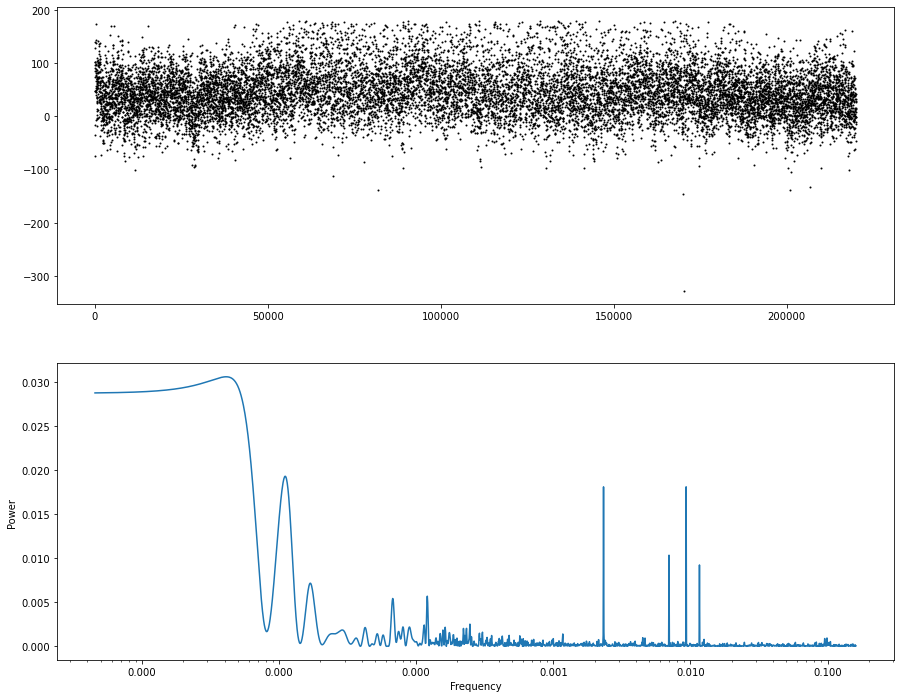

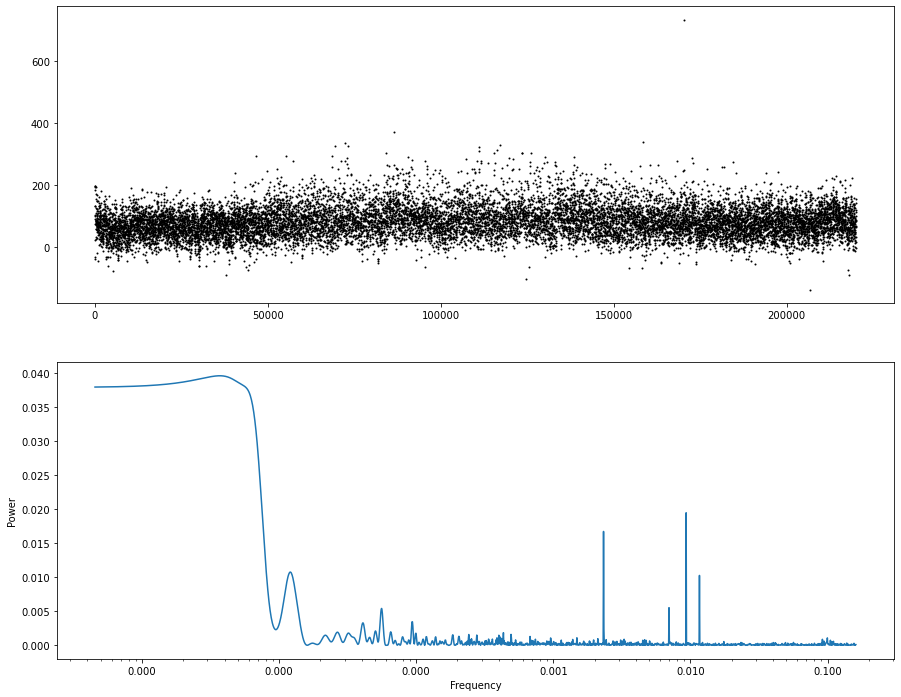

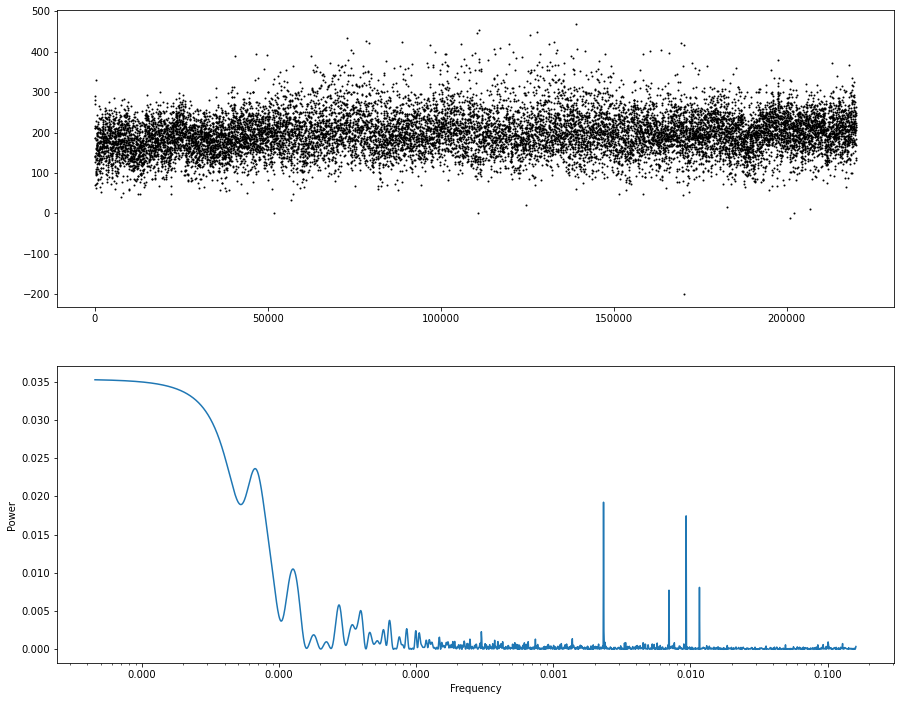

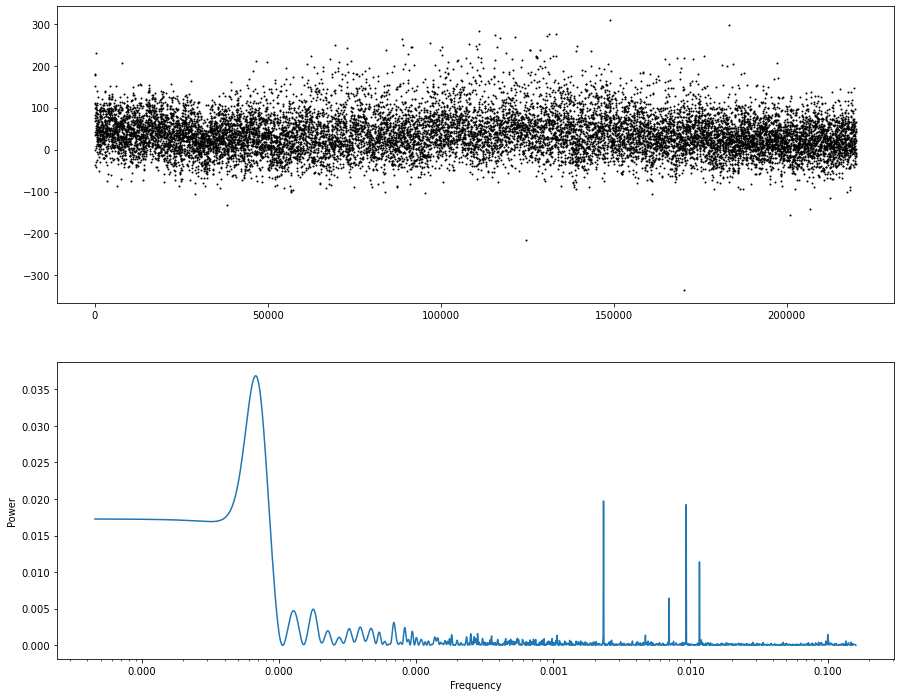

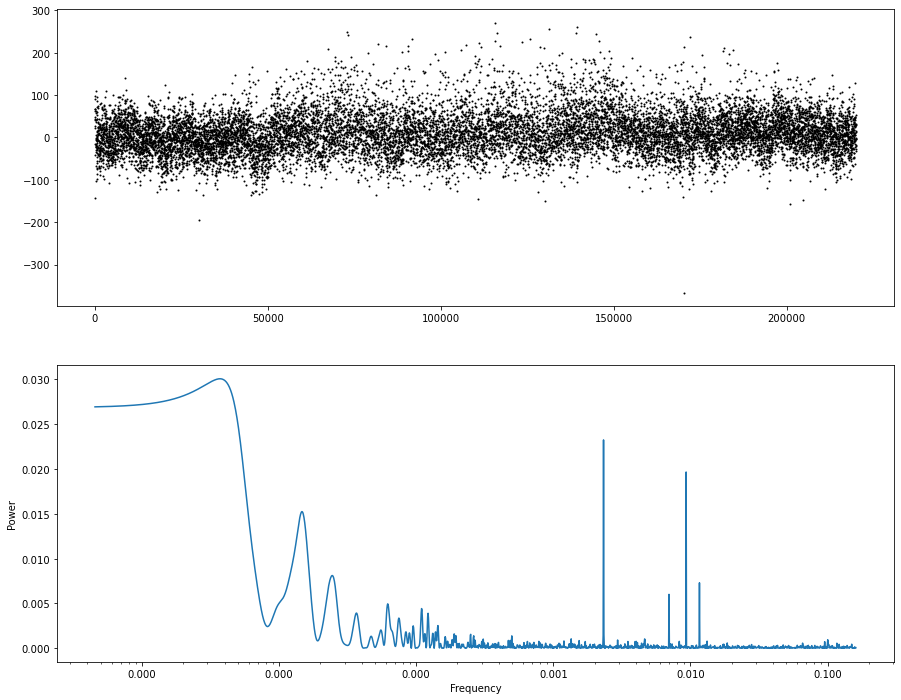

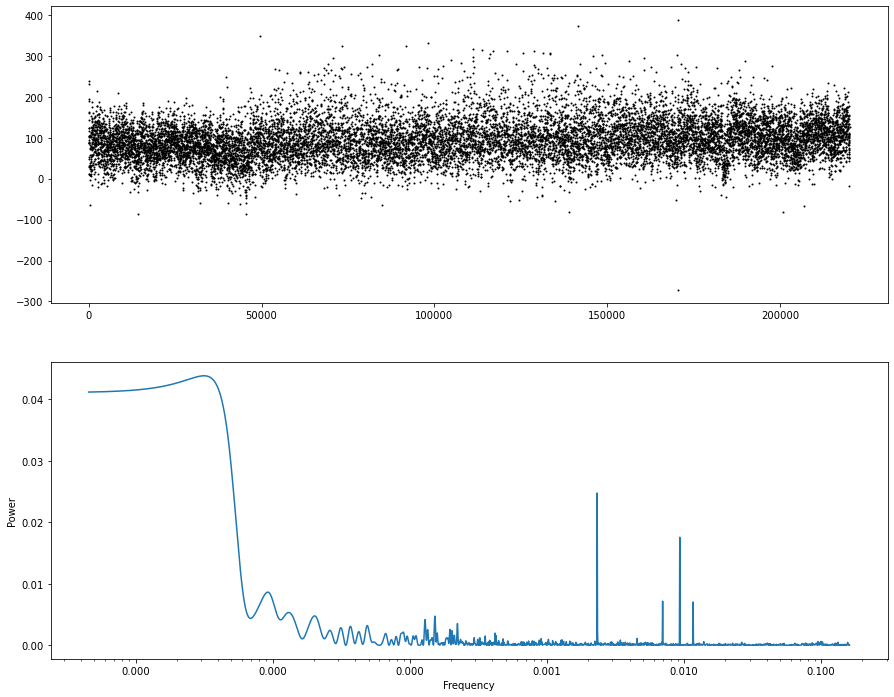

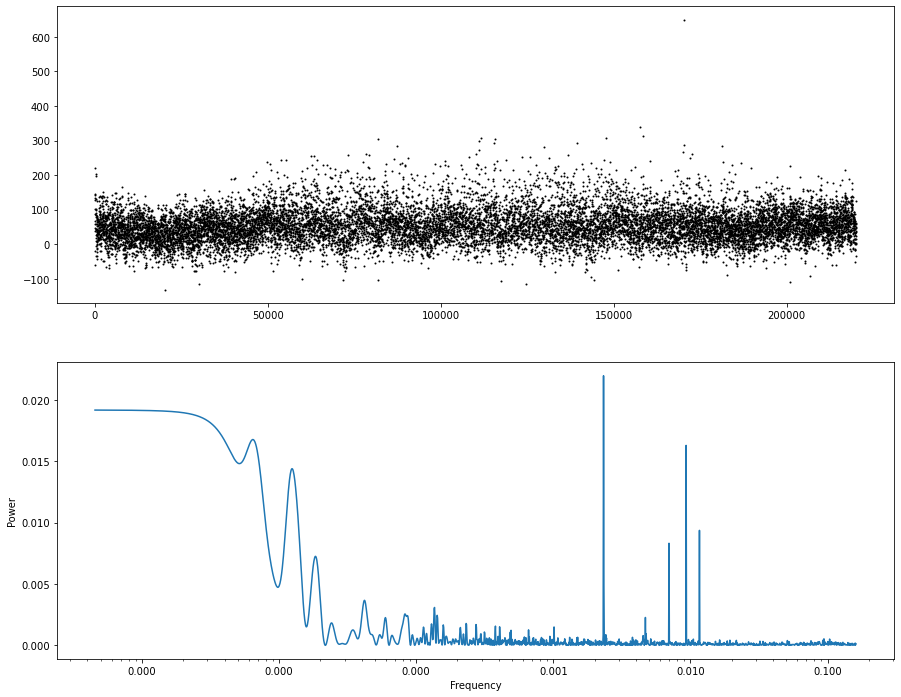

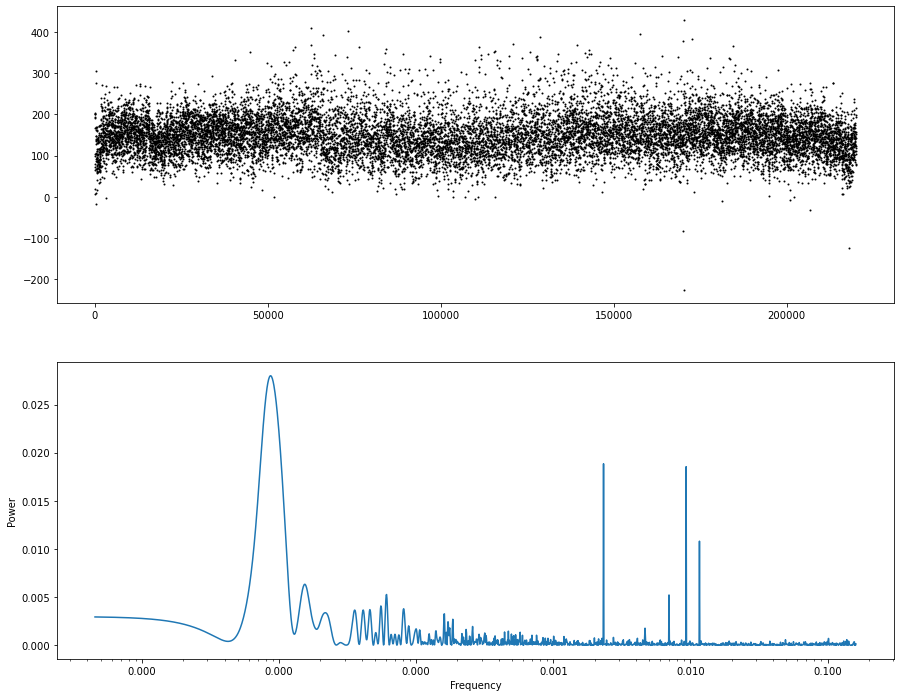

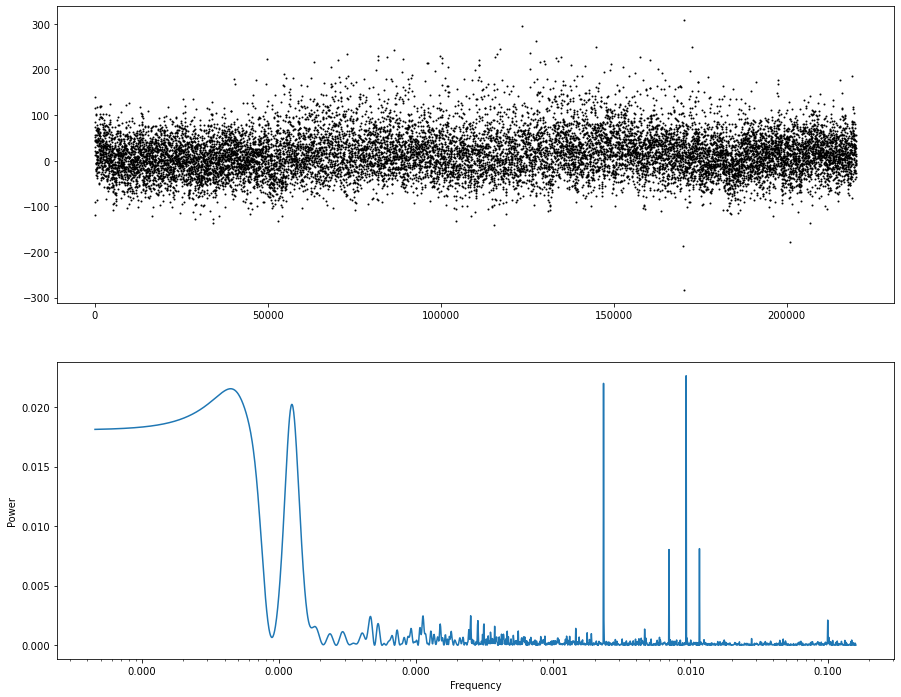

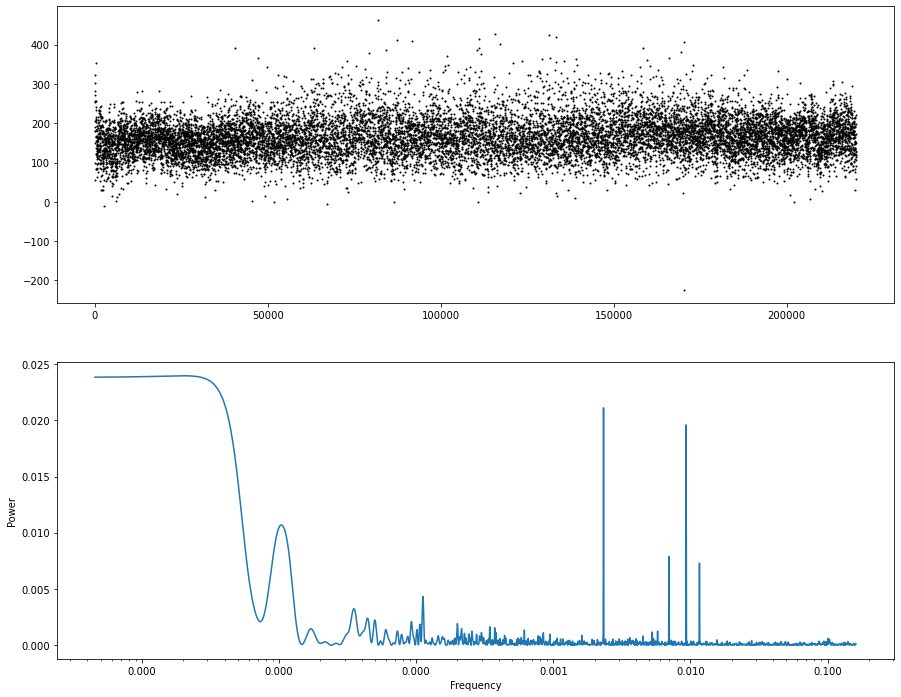

In [20]:
from matplotlib.ticker import ScalarFormatter

frequency_list = []
power_list = []

for num in range(0, len(all_masked_times)):
    x = all_masked_times[num]
    y = all_masked_cols[num]

    # plot with labels and synthetic planet of amplitude 0.78 m/s and 1 year period
    fig, axes = plt.subplots(2,1,figsize=(15, 12))
    ax = axes[0]
    ax.plot(x, y,".", color='k')

    frequency, power = LombScargle(x, y).autopower()
    min_freq = 4.544628249409198e-07 #np.min(frequency)
    max_freq = 0.16088029449191055 #np.max(frequency)
    print("min freq: "+str(min_freq)+" max freq: "+str(max_freq))

    frequency2 = np.geomspace(min_freq, max_freq, 2000)#len(frequency))
    power = LombScargle(x, y).power(frequency2)
    
    frequency_list.append(frequency2)
    power_list.append(power)

    ax = axes[1]
    ax.plot(frequency2, power)
    #plt.xlim(0,100)
    ax.set_xscale('log')
    ax.set_xscale('log')
    for axis in [ax.xaxis, ax.yaxis]:
        axis.set_major_formatter(ScalarFormatter())
    #plt.ylim(-0.005, 0.03)
    ax.set_xlabel("Frequency")
    ax.set_ylabel("Power")

    best_frequency = frequency2[np.argmax(power)]
    print("best period: "+str(1/best_frequency))

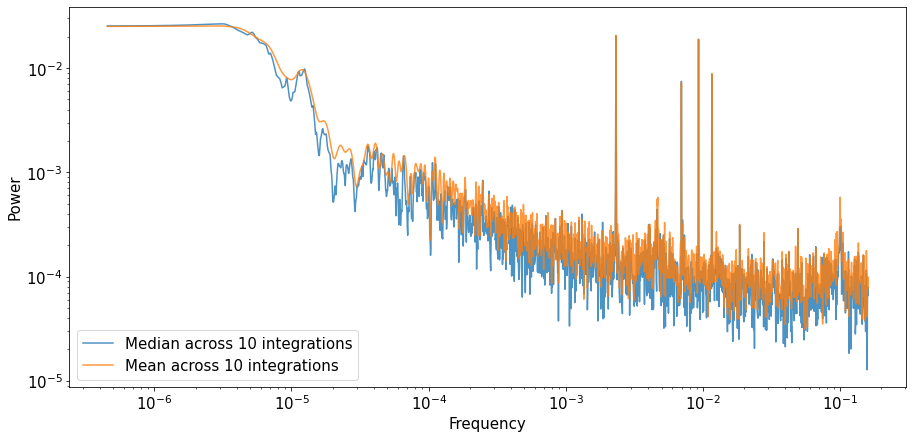

In [21]:
plt.rcParams['font.size'] = 15

med_freq = np.median(frequency_list, axis=0)
med_power = np.median(power_list, axis=0)

mean_freq = np.mean(frequency_list, axis=0)
mean_power = np.mean(power_list, axis=0)


fig, ax = plt.subplots(1,1,figsize=(15, 7))
ax.plot(med_freq, med_power, label="Median across 10 integrations", alpha=0.8)
ax.plot(mean_freq, mean_power, label="Mean across 10 integrations", alpha=0.8)
#ax.plot(mean_freq, (1/(mean_freq)), label="1/f")
ax.set_xscale('log')
ax.set_yscale('log')
#for axis in [ax.xaxis, ax.yaxis]:
#    axis.set_major_formatter(ScalarFormatter())
#plt.ylim(-0.005, 0.03)
ax.set_xlabel("Frequency")
ax.set_ylabel("Power")
ax.legend()

In [22]:
import pandas as pd

# write these results to a csv for later visulation purposes
data = {'med_freq': med_freq,
       'mean_freq': mean_freq,
        'med_power': med_power,
       'mean_power': mean_power}

pd_csv = pd.DataFrame(data = data)
pd_csv.to_csv("original_power_spectrum.csv")


In [23]:
len(frequency)

177001

## Line subtraction

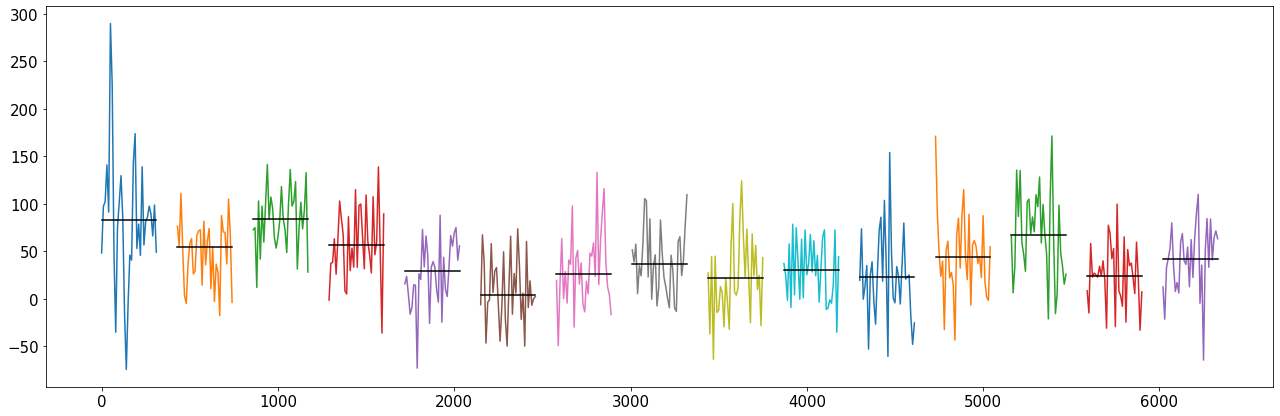

In [24]:
time_np = np.arange(0, 320, 10)

fig, ax = plt.subplots(1,1,figsize=(22, 7))
for number in range(0, 15):#len(col_arrays0)):
    median_col = np.median(col_arrays0[number])
    mean_col = np.mean(col_arrays0[number])
    plt.plot(time_full[number], col_arrays0[number])
    plt.plot(time_full[number], [median_col]*len(time_full[number]), color='k')
    
#fig, ax = plt.subplots(1,1,figsize=(22, 7))
#for number in range(15, 30):#len(col_arrays0)):
#    plt.plot(time_full[number], col_arrays0[number])

In [25]:
np.shape(np.transpose(time_full[number]).reshape((32, 1)))

(32, 1)

In [63]:
np.shape(np.transpose(time_full[number]))

def LS_fit(time_full, numbers, col_arrays, order):

    a_coeff_list = []
    x_list = []
    
    for number in numbers:
        # perform the L-S fit --------------
        n_cols = len(time_full[number])# + 1
        n_rows = len(col_arrays)  # len(ccf_list_np)<---- unsmoothed
        x = np.zeros((n_cols,order+1))

        if order == 1:
            x[:, 0] = 1
            x[:, 1] = time_full[number]
            
        if order == 2:
            x[:, 0] = 1
            x[:, 1] = time_full[number]
            x[:, 2] = time_full[number]**2
            
        if order == 3:
            x[:, 0] = 1
            x[:, 1] = time_full[number]
            x[:, 2] = time_full[number]**2
            x[:, 3] = time_full[number]**3


        #for i in np.arange(1, 32):
        #    x[:, i] = np.transpose(time_full[number]).reshape((32, 1))[i]  # (for all observations)
        y = col_arrays[number]

        alpha = x.transpose().dot(x)
        beta = x.transpose().dot(y)

        # and finally we can write a_coeff = alpha^-1 * beta
        inv_alpha = np.linalg.inv(alpha)
        a_coeff = inv_alpha.dot(beta)
        a_coeff_list.append(a_coeff.tolist())
        x_list.append(x.tolist())
        
    return a_coeff_list, x_list

In [64]:
def LS_fit_one(time_full, col_arrays, order):

    # perform the L-S fit --------------
    n_cols = len(time_full)# + 1
    n_rows = len(col_arrays)  # len(ccf_list_np)<---- unsmoothed
    x = np.zeros((n_rows,order+1))
    
    if order == 1:
        x[:, 0] = 1
        x[:, 1] = time_full
    
    if order == 2:
        x[:, 0] = 1
        x[:, 1] = time_full
        x[:, 2] = time_full**2
        
    if order == 3:
        x[:, 0] = 1
        x[:, 1] = time_full
        x[:, 2] = time_full**2
        x[:, 3] = time_full**3
    

    #for i in np.arange(1, 32):
    #    x[:, i] = np.transpose(time_full[number]).reshape((32, 1))[i]  # (for all observations)
    y = col_arrays

    alpha = x.transpose().dot(x)
    beta = x.transpose().dot(y)

    # and finally we can write a_coeff = alpha^-1 * beta
    inv_alpha = np.linalg.inv(alpha)
    a_coeff = inv_alpha.dot(beta)
        
    return a_coeff, x

In [65]:
def return_xfull(time_full):
    x = np.zeros((32,3))

    x[:, 0] = 1
    x[:, 1] = time_full
    x[:, 2] = time_full[number]**2
    
    return x

In [66]:
masked_col_array0 = []
masked_time_full = []
for num in range(0, len(col_arrays0)):
    masked_col_array0.append(np.array(col_arrays0[num])[np.where(np.array(col_arrays0[num])<ymin)])
    masked_time_full.append(np.array(time_full[num])[np.where(np.array(col_arrays0[num])<ymin)])
                    
len(masked_col_array0)

512

In [67]:
masked_time_full[0]

array([  0,  10,  20,  30,  40,  70,  80,  90, 100, 110, 120, 130, 140,
       150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250, 260, 270,
       280, 290, 300, 310])

In [32]:
    a_coeff_list = []
    x_list = []
    
    numbers_max = 5
    numbers =np.arange(0, numbers_max)
    
    for number in numbers:
        # perform the L-S fit --------------
        n_cols = len(masked_time_full[number])# + 1
        n_rows = len(masked_col_array0)  # len(ccf_list_np)<---- unsmoothed
        x = np.zeros((n_cols,3))

        x[:, 0] = 1
        x[:, 1] = masked_time_full[number]
        x[:, 2] = masked_time_full[number]**2


        #for i in np.arange(1, 32):
        #    x[:, i] = np.transpose(time_full[number]).reshape((32, 1))[i]  # (for all observations)
        y = masked_col_array0[number]

        alpha = x.transpose().dot(x)
        beta = x.transpose().dot(y)

        # and finally we can write a_coeff = alpha^-1 * beta
        inv_alpha = np.linalg.inv(alpha)
        a_coeff = inv_alpha.dot(beta)
        a_coeff_list.append(a_coeff.tolist())
        x_list.append(x.tolist())

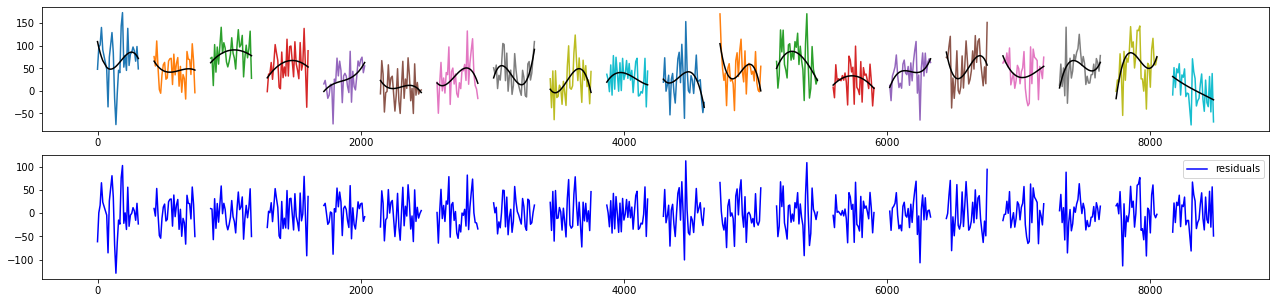

In [71]:
numbers_max = 20

a_coeff_list, x_list = LS_fit(masked_time_full, np.arange(0, numbers_max), masked_col_array0, 3) #time_full, np.arange(0, numbers_max), col_arrays0)#

fig, axes = plt.subplots(2,1,figsize=(22, 5))

ax = axes[0]
for number in range(0, numbers_max):#len(col_arrays0)):
    ax.plot(masked_time_full[number], masked_col_array0[number])
    ax.plot(masked_time_full[number], np.array(x_list[number]).dot(a_coeff_list[number]), color='k')

#ax.set_xlim(40000, 50000)
    
ax = axes[1]
number = 0
ax.plot(masked_time_full[number], masked_col_array0[number]-np.array(x_list[number]).dot(a_coeff_list[number]), 
            label="residuals", color='b')
for number in range(1, numbers_max):#len(col_arrays0)):
    ax.plot(masked_time_full[number], masked_col_array0[number]-np.array(x_list[number]).dot(a_coeff_list[number]), 
            color='b')
    
ax.legend()

In [34]:
masked_time_full[number]

array([3870, 3880, 3890, 3900, 3910, 3920, 3930, 3940, 3950, 3960, 3970,
       3980, 3990, 4000, 4010, 4020, 4030, 4040, 4050, 4060, 4070, 4080,
       4090, 4100, 4110, 4120, 4130, 4140, 4150, 4160, 4170, 4180])

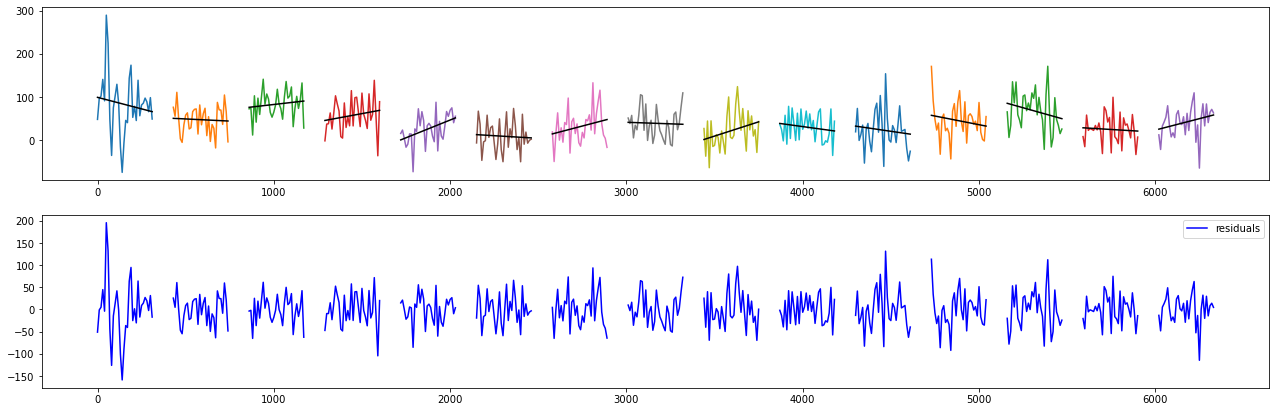

In [74]:
numbers_max = 15#512

a_coeff_list, x_list = LS_fit(time_full, np.arange(0, numbers_max), col_arrays0, 1)

fig, axes = plt.subplots(2,1,figsize=(22, 7))


ax = axes[0]
for number in range(0, numbers_max):#len(col_arrays0)):
    ax.plot(time_full[number], col_arrays0[number])
    ax.plot(time_full[number], np.array(x_list[number]).dot(a_coeff_list[number]), color='k')

#ax.set_xlim(40000, 50000)
    
ax = axes[1]
number = 0
ax.plot(time_full[number], col_arrays0[number]-np.array(x_list[number]).dot(a_coeff_list[number]), 
            label="residuals", color='b')
for number in range(1, numbers_max):#len(col_arrays0)):
    ax.plot(time_full[number], col_arrays0[number]-np.array(x_list[number]).dot(a_coeff_list[number]), 
            color='b')

ax.legend()

In [337]:
len(col_arrays0)

512

In [338]:
len(col_arrays0[number])

32

## Visualize images before correction

0
1
2
3
4
5
6
7
8
9


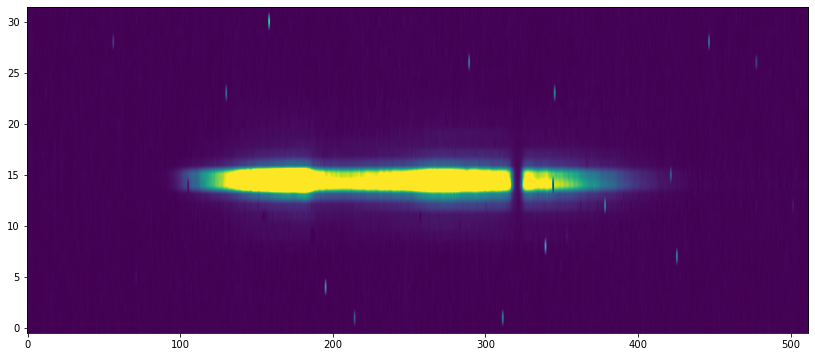

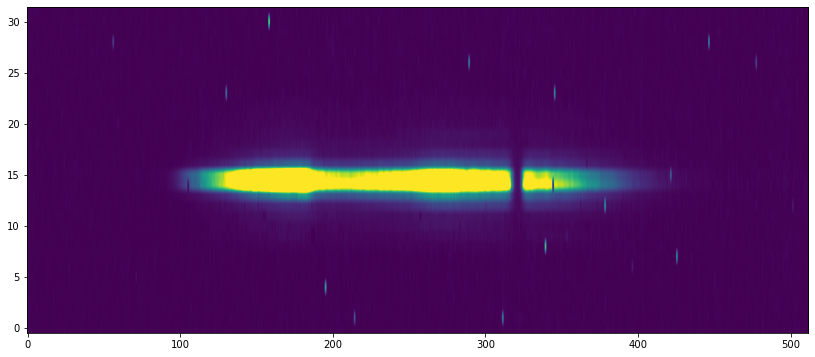

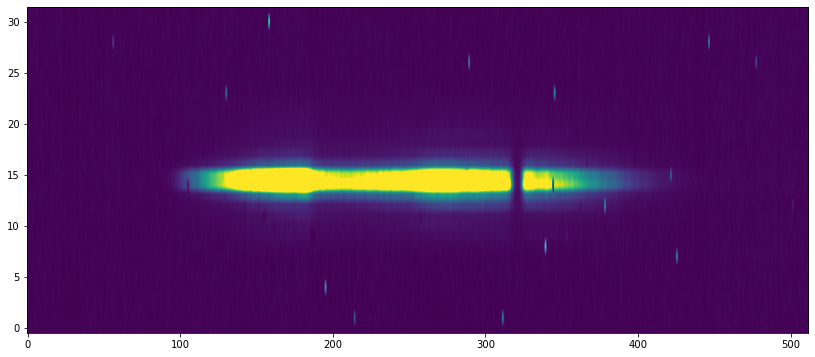

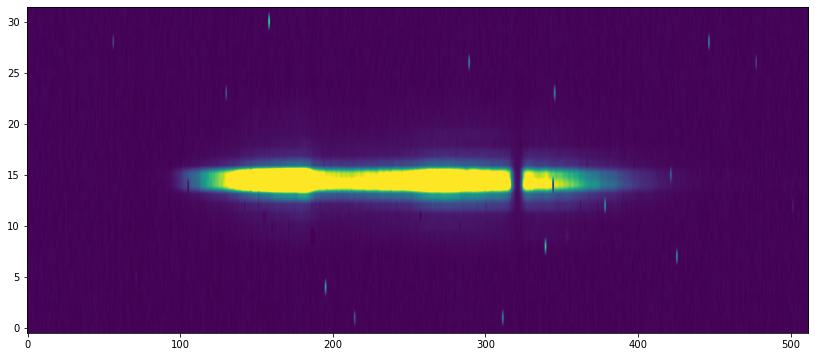

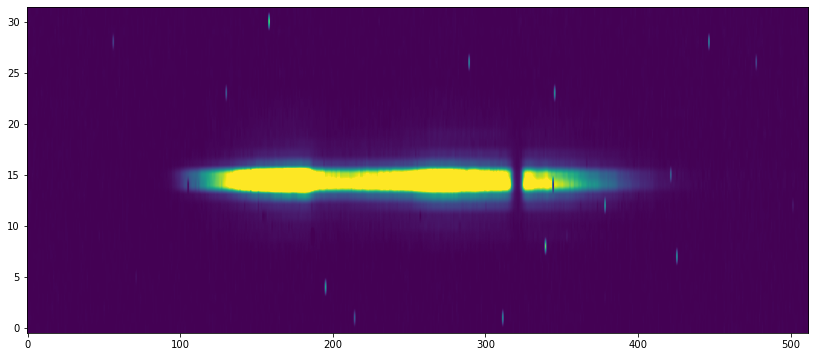

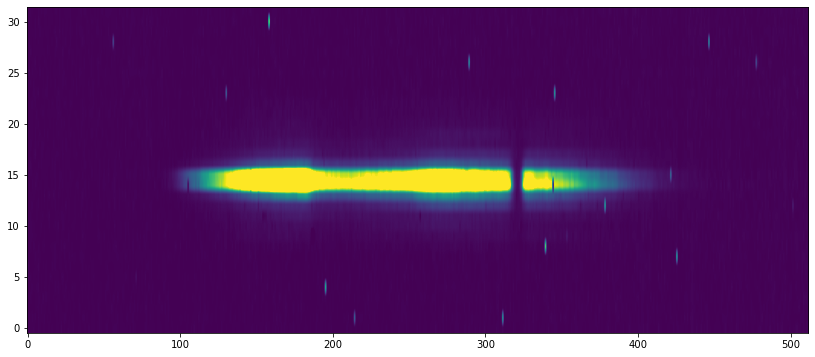

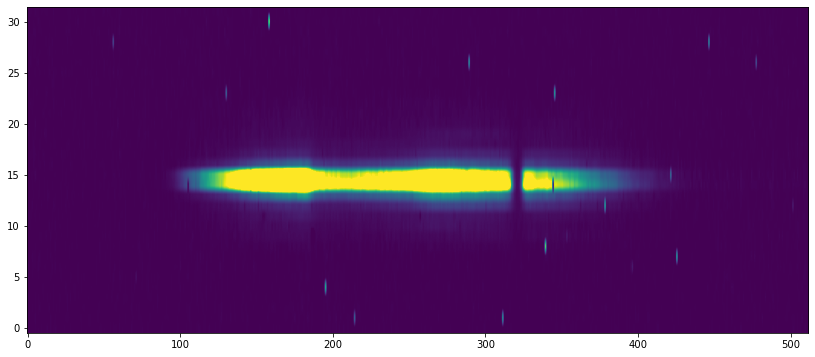

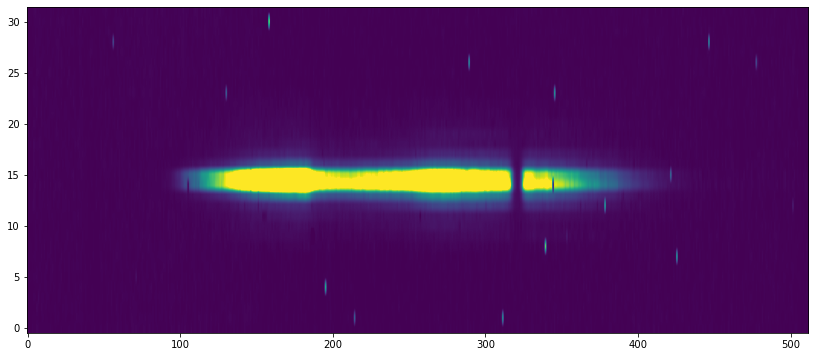

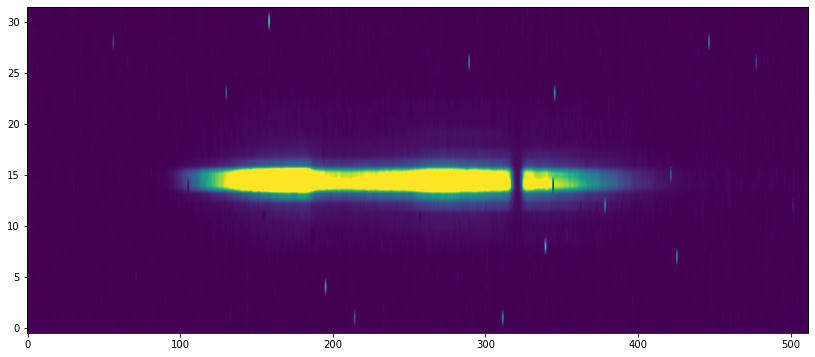

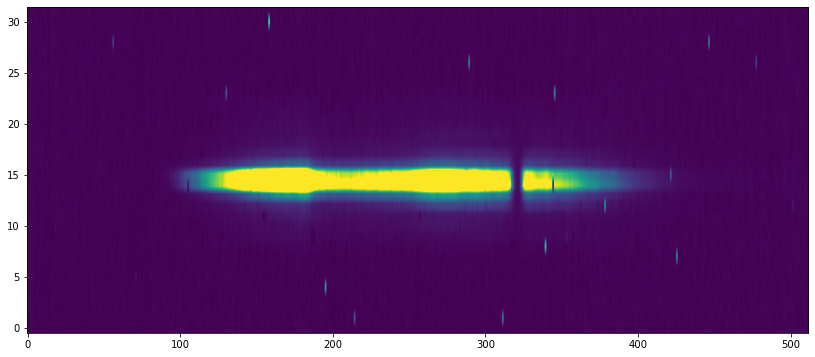

In [43]:
%matplotlib inline
for i in range(0, 10):
    print(i)
    fig, ax = plt.subplots(1, 1, figsize=(14, 6))
    plt.imshow(hdul[1].data[i,1,:,:,], origin = 'lower', aspect='auto',  vmin=0, vmax=1e4)

In [44]:
np.shape(hdul[1].data[:,:,:,:,])

(10, 3, 32, 512)

## Linear Correction

In [45]:
integr_num = 0
group_num = 0
col_num = 235
col_values= hdul[1].data[integr_num,group_num,:,col_num]
#print(col_values)
col_values[np.where(col_values<ymin)]
print(time_full[col_num][np.where(col_values<ymin)], col_values[np.where(col_values<ymin)])
if len(time_full[col_num][np.where(col_values<ymin)])<2:
    print("too short")
    
    
time_input = time_full[col_num][np.where(col_values<ymin)]
col_input = col_values[np.where(col_values<ymin)]

# perform the L-S fit --------------
n_cols = len(time_input)# + 1
n_rows = len(col_input)  # len(ccf_list_np)<---- unsmoothed
x = np.zeros((n_rows,3))

x[:, 0] = 1
x[:, 1] = time_input
x[:, 2] = time_input[number]**2



#for i in np.arange(1, 32):
#    x[:, i] = np.transpose(time_full[number]).reshape((32, 1))[i]  # (for all observations)
y = col_input

alpha = x.transpose().dot(x)
beta = x.transpose().dot(y)

# and finally we can write a_coeff = alpha^-1 * beta
inv_alpha = np.linalg.pinv(alpha)
a_coeff = inv_alpha.dot(beta)    

#a_coeff, x = LS_fit_one(time_full[col_num][np.where(col_values<ymin)], col_values[np.where(col_values<ymin)])

[101050 101060 101070 101080 101090 101100 101110 101120 101130 101140
 101150 101160 101240 101250 101260 101270 101280 101290 101300 101310
 101320 101330 101340 101350 101360] [ 17.476562   56.24536    16.012207   68.48535    32.41223   -41.496826
  31.852295   35.32544   -42.987793   98.28931    87.73218   142.64526
  94.20557    44.53955    52.645264   81.82568    14.925293   29.772217
  55.93994    41.934326   85.65137    90.87976    48.432617   50.73242
   7.2592773]


In [46]:
# apply linear correction

def lin_corr(integr_nums, group_nums, colsize, rowsize):
    col_corr_arrays = []
    col_values_list =[]
    image =  np.zeros((10, 3, 32, 512))
    image_corr = np.zeros((10, 3, 32, 512))
    
    for group_num in range(0, group_nums):
        for integr_num in range(0, integr_nums):
            for col_num in range(0, rowsize):
                    print(integr_num,group_num,col_num)
                    col_values= hdul[1].data[integr_num,group_num,:,col_num]
                    image[integr_num,group_num,:,col_num] = hdul[1].data[integr_num,group_num,:,col_num]
                    col_values_list.append(col_values)
                    
                    if len(time_full[col_num][np.where(col_values<ymin)])<2:
                        print("too short")
                        continue
                    
                    a_coeff, x = LS_fit_one(time_full[col_num][np.where(col_values<ymin)], col_values[np.where(col_values<ymin)])
                    col_corr_values = col_values - np.array(return_xfull(time_full[col_num])).dot(a_coeff)
                    col_corr_arrays.append(col_corr_values.tolist())
                    
                    #fig, axes = plt.subplots(2, 1, figsize=(8, 3), gridspec_kw={'height_ratios': [2, 1.5]})
                    
                    #ax = axes[0]
                    #ax.plot(time_full[col_num], hdul[1].data[integr_num,group_num,:,col_num], label="raw")
                    #ax.plot(time_full[col_num], np.array(x).dot(a_coeff), label="lin corr")
                    #ax.legend()
                    
                    #ax = axes[1]
                    #ax.plot(time_full[col_num], col_corr_values, label ="corrected")
                    #ax.set_ylabel("Residuals")
                    #ax.legend()
                    
                    image_corr[integr_num,group_num,:,col_num] = col_corr_values
                    #print(image_corr)
                    
    
    #col_arrays_flat = [item for sublist in col_arrays for item in sublist]
    
    return col_corr_arrays, col_values_list, image, image_corr

In [47]:
col_corr_arrays, col_values_list,image, image_corr = lin_corr(integr_nums=10, group_nums=3, colsize=1, rowsize=512)

0 0 0
0 0 1
0 0 2
0 0 3
0 0 4
0 0 5
0 0 6
0 0 7
0 0 8
0 0 9
0 0 10
0 0 11
0 0 12
0 0 13
0 0 14
0 0 15
0 0 16
0 0 17
0 0 18
0 0 19
0 0 20
0 0 21
0 0 22
0 0 23
0 0 24
0 0 25
0 0 26
0 0 27
0 0 28
0 0 29
0 0 30
0 0 31
0 0 32
0 0 33
0 0 34
0 0 35
0 0 36
0 0 37
0 0 38
0 0 39
0 0 40
0 0 41
0 0 42
0 0 43
0 0 44
0 0 45
0 0 46
0 0 47
0 0 48
0 0 49
0 0 50
0 0 51
0 0 52
0 0 53
0 0 54
0 0 55
0 0 56
0 0 57
0 0 58
0 0 59
0 0 60
0 0 61
0 0 62
0 0 63
0 0 64
0 0 65
0 0 66
0 0 67
0 0 68
0 0 69
0 0 70
0 0 71
0 0 72
0 0 73
0 0 74
0 0 75
0 0 76
0 0 77
0 0 78
0 0 79
0 0 80
0 0 81
0 0 82
0 0 83
0 0 84
0 0 85
0 0 86
0 0 87
0 0 88
0 0 89
0 0 90
0 0 91
0 0 92
0 0 93
0 0 94
0 0 95
0 0 96
0 0 97
0 0 98
0 0 99
0 0 100
0 0 101
0 0 102
0 0 103
0 0 104
0 0 105
0 0 106
0 0 107
0 0 108
0 0 109
0 0 110
0 0 111
0 0 112
0 0 113
0 0 114
0 0 115
0 0 116
0 0 117
0 0 118
0 0 119
0 0 120
0 0 121
0 0 122
0 0 123
0 0 124
0 0 125
0 0 126
0 0 127
0 0 128
0 0 129
0 0 130
0 0 131
0 0 132
0 0 133
0 0 134
0 0 135
0 0 136
0 0 137
0 0 13

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



0 491
1 0 492
1 0 493
1 0 494
1 0 495
1 0 496
1 0 497
1 0 498
1 0 499
1 0 500
1 0 501
1 0 502
1 0 503
1 0 504
1 0 505
1 0 506
1 0 507
1 0 508
1 0 509
1 0 510
1 0 511
2 0 0
2 0 1
2 0 2
2 0 3
2 0 4
2 0 5
2 0 6
2 0 7
2 0 8
2 0 9
2 0 10
2 0 11
2 0 12
2 0 13
2 0 14
2 0 15
2 0 16
2 0 17
2 0 18
2 0 19
2 0 20
2 0 21
2 0 22
2 0 23
2 0 24
2 0 25
2 0 26
2 0 27
2 0 28
2 0 29
2 0 30
2 0 31
2 0 32
2 0 33
2 0 34
2 0 35
2 0 36
2 0 37
2 0 38
2 0 39
2 0 40
2 0 41
2 0 42
2 0 43
2 0 44
2 0 45
2 0 46
2 0 47
2 0 48
2 0 49
2 0 50
2 0 51
2 0 52
2 0 53
2 0 54
2 0 55
2 0 56
2 0 57
2 0 58
2 0 59
2 0 60
2 0 61
2 0 62
2 0 63
2 0 64
2 0 65
2 0 66
2 0 67
2 0 68
2 0 69
2 0 70
2 0 71
2 0 72
2 0 73
2 0 74
2 0 75
2 0 76
2 0 77
2 0 78
2 0 79
2 0 80
2 0 81
2 0 82
2 0 83
2 0 84
2 0 85
2 0 86
2 0 87
2 0 88
2 0 89
2 0 90
2 0 91
2 0 92
2 0 93
2 0 94
2 0 95
2 0 96
2 0 97
2 0 98
2 0 99
2 0 100
2 0 101
2 0 102
2 0 103
2 0 104
2 0 105
2 0 106
2 0 107
2 0 108
2 0 109
2 0 110
2 0 111
2 0 112
2 0 113
2 0 114
2 0 115
2 0 116
2 0 117


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




3 0 497
3 0 498
3 0 499
3 0 500
3 0 501
3 0 502
3 0 503
3 0 504
3 0 505
3 0 506
3 0 507
3 0 508
3 0 509
3 0 510
3 0 511
4 0 0
4 0 1
4 0 2
4 0 3
4 0 4
4 0 5
4 0 6
4 0 7
4 0 8
4 0 9
4 0 10
4 0 11
4 0 12
4 0 13
4 0 14
4 0 15
4 0 16
4 0 17
4 0 18
4 0 19
4 0 20
4 0 21
4 0 22
4 0 23
4 0 24
4 0 25
4 0 26
4 0 27
4 0 28
4 0 29
4 0 30
4 0 31
4 0 32
4 0 33
4 0 34
4 0 35
4 0 36
4 0 37
4 0 38
4 0 39
4 0 40
4 0 41
4 0 42
4 0 43
4 0 44
4 0 45
4 0 46
4 0 47
4 0 48
4 0 49
4 0 50
4 0 51
4 0 52
4 0 53
4 0 54
4 0 55
4 0 56
4 0 57
4 0 58
4 0 59
4 0 60
4 0 61
4 0 62
4 0 63
4 0 64
4 0 65
4 0 66
4 0 67
4 0 68
4 0 69
4 0 70
4 0 71
4 0 72
4 0 73
4 0 74
4 0 75
4 0 76
4 0 77
4 0 78
4 0 79
4 0 80
4 0 81
4 0 82
4 0 83
4 0 84
4 0 85
4 0 86
4 0 87
4 0 88
4 0 89
4 0 90
4 0 91
4 0 92
4 0 93
4 0 94
4 0 95
4 0 96
4 0 97
4 0 98
4 0 99
4 0 100
4 0 101
4 0 102
4 0 103
4 0 104
4 0 105
4 0 106
4 0 107
4 0 108
4 0 109
4 0 110
4 0 111
4 0 112
4 0 113
4 0 114
4 0 115
4 0 116
4 0 117
4 0 118
4 0 119
4 0 120
4 0 121
4 0 122
4 0 1

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



457
5 0 458
5 0 459
5 0 460
5 0 461
5 0 462
5 0 463
5 0 464
5 0 465
5 0 466
5 0 467
5 0 468
5 0 469
5 0 470
5 0 471
5 0 472
5 0 473
5 0 474
5 0 475
5 0 476
5 0 477
5 0 478
5 0 479
5 0 480
5 0 481
5 0 482
5 0 483
5 0 484
5 0 485
5 0 486
5 0 487
5 0 488
5 0 489
5 0 490
5 0 491
5 0 492
5 0 493
5 0 494
5 0 495
5 0 496
5 0 497
5 0 498
5 0 499
5 0 500
5 0 501
5 0 502
5 0 503
5 0 504
5 0 505
5 0 506
5 0 507
5 0 508
5 0 509
5 0 510
5 0 511
6 0 0
6 0 1
6 0 2
6 0 3
6 0 4
6 0 5
6 0 6
6 0 7
6 0 8
6 0 9
6 0 10
6 0 11
6 0 12
6 0 13
6 0 14
6 0 15
6 0 16
6 0 17
6 0 18
6 0 19
6 0 20
6 0 21
6 0 22
6 0 23
6 0 24
6 0 25
6 0 26
6 0 27
6 0 28
6 0 29
6 0 30
6 0 31
6 0 32
6 0 33
6 0 34
6 0 35
6 0 36
6 0 37
6 0 38
6 0 39
6 0 40
6 0 41
6 0 42
6 0 43
6 0 44
6 0 45
6 0 46
6 0 47
6 0 48
6 0 49
6 0 50
6 0 51
6 0 52
6 0 53
6 0 54
6 0 55
6 0 56
6 0 57
6 0 58
6 0 59
6 0 60
6 0 61
6 0 62
6 0 63
6 0 64
6 0 65
6 0 66
6 0 67
6 0 68
6 0 69
6 0 70
6 0 71
6 0 72
6 0 73
6 0 74
6 0 75
6 0 76
6 0 77
6 0 78
6 0 79
6 0 80
6 0 81


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




7 0 415
7 0 416
7 0 417
7 0 418
7 0 419
7 0 420
7 0 421
7 0 422
7 0 423
7 0 424
7 0 425
7 0 426
7 0 427
7 0 428
7 0 429
7 0 430
7 0 431
7 0 432
7 0 433
7 0 434
7 0 435
7 0 436
7 0 437
7 0 438
7 0 439
7 0 440
7 0 441
7 0 442
7 0 443
7 0 444
7 0 445
7 0 446
7 0 447
7 0 448
7 0 449
7 0 450
7 0 451
7 0 452
7 0 453
7 0 454
7 0 455
7 0 456
7 0 457
7 0 458
7 0 459
7 0 460
7 0 461
7 0 462
7 0 463
7 0 464
7 0 465
7 0 466
7 0 467
7 0 468
7 0 469
7 0 470
7 0 471
7 0 472
7 0 473
7 0 474
7 0 475
7 0 476
7 0 477
7 0 478
7 0 479
7 0 480
7 0 481
7 0 482
7 0 483
7 0 484
7 0 485
7 0 486
7 0 487
7 0 488
7 0 489
7 0 490
7 0 491
7 0 492
7 0 493
7 0 494
7 0 495
7 0 496
7 0 497
7 0 498
7 0 499
7 0 500
7 0 501
7 0 502
7 0 503
7 0 504
7 0 505
7 0 506
7 0 507
7 0 508
7 0 509
7 0 510
7 0 511
8 0 0
8 0 1
8 0 2
8 0 3
8 0 4
8 0 5
8 0 6
8 0 7
8 0 8
8 0 9
8 0 10
8 0 11
8 0 12
8 0 13
8 0 14
8 0 15
8 0 16
8 0 17
8 0 18
8 0 19
8 0 20
8 0 21
8 0 22
8 0 23
8 0 24
8 0 25
8 0 26
8 0 27
8 0 28
8 0 29
8 0 30
8 0 31
8 0 32
8 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



511
0 1 0
0 1 1
0 1 2
0 1 3
0 1 4
0 1 5
0 1 6
0 1 7
0 1 8
0 1 9
0 1 10
0 1 11
0 1 12
0 1 13
0 1 14
0 1 15
0 1 16
0 1 17
0 1 18
0 1 19
0 1 20
0 1 21
0 1 22
0 1 23
0 1 24
0 1 25
0 1 26
0 1 27
0 1 28
0 1 29
0 1 30
0 1 31
0 1 32
0 1 33
0 1 34
0 1 35
0 1 36
0 1 37
0 1 38
0 1 39
0 1 40
0 1 41
0 1 42
0 1 43
0 1 44
0 1 45
0 1 46
0 1 47
0 1 48
0 1 49
0 1 50
0 1 51
0 1 52
0 1 53
0 1 54
0 1 55
0 1 56
0 1 57
0 1 58
0 1 59
0 1 60
0 1 61
0 1 62
0 1 63
0 1 64
0 1 65
0 1 66
0 1 67
0 1 68
0 1 69
0 1 70
0 1 71
0 1 72
0 1 73
0 1 74
0 1 75
0 1 76
0 1 77
0 1 78
0 1 79
0 1 80
0 1 81
0 1 82
0 1 83
0 1 84
0 1 85
0 1 86
0 1 87
0 1 88
0 1 89
0 1 90
0 1 91
0 1 92
0 1 93
0 1 94
0 1 95
0 1 96
0 1 97
0 1 98
0 1 99
0 1 100
0 1 101
0 1 102
0 1 103
0 1 104
0 1 105
0 1 106
0 1 107
0 1 108
0 1 109
0 1 110
0 1 111
0 1 112
0 1 113
0 1 114
0 1 115
0 1 116
0 1 117
0 1 118
0 1 119
0 1 120
0 1 121
0 1 122
0 1 123
0 1 124
0 1 125
0 1 126
0 1 127
0 1 128
0 1 129
0 1 130
0 1 131
0 1 132
0 1 133
0 1 134
0 1 135
0 1 136
0 1 137
0 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



2 1 111
2 1 112
2 1 113
2 1 114
2 1 115
2 1 116
2 1 117
2 1 118
2 1 119
2 1 120
2 1 121
2 1 122 1 206
2 1 207
2 1 208
2 1 209
2 1 210
2 1 211
2 1 212
2 1 213
2 1 214
2 1 215
2 1 216
2 1 217
2 1 218
2 1 219
2 1 220
2 1 221
2 1 222
2 1 223
2 1 224
2 1 225
2 1 226
2 1 227
2 1 228
2 1 229
2 1 230
2 1 231
2 1 232
2 1 233
2 1 234
2 1 235
2 1 236
2 1 237
2 1 238
2 1 239
2 1 240
2 1 241
2 1 242
2 1 243
2 1 244
2 1 245
2 1 246
2 1 247
2 1 248
2 1 249
2 1 250
2 1 251
2 1 252
2 1 253
2 1 254
2 1 255
2 1 256
2 1 257
2 1 258
2 1 259
2 1 260
2 1 261
2 1 262
2 1 263
2 1 264
2 1 265
2 1 266
2 1 267
2 1 268
2 1 269
2 1 270
2 1 271
2 1 272
2 1 273
2 1 274
2 1 275
2 1 276
2 1 277
2 1 278
2 1 279
2 1 280
2 1 281
2 1 282
2 1 283
2 1 284
2 1 285
2 1 286
2 1 287
2 1 288
2 1 289
2 1 290
2 1 291
2 1 292
2 1 293
2 1 294
2 1 295
2 1 296
2 1 297
2 1 298
2 1 299
2 1 300
2 1 301
2 1 302
2 1 303
2 1 304
2 1 305
2 1 306
2 1 307
2 1 308
2 1 309
2 1 310
2 1 311
2 1 312
2 1 313
2 1 314
2 1 315
2 1 316
2 1 317
2 1 318
2 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1 361
4 1 362
4 1 363
4 1 364
4 1 365
4 1 366
4 1 367
4 1 368
4 1 369
4 1 370
4 1 371
4 1 372
4 1 373
4 1 374
4 1 375
4 1 376
4 1 377
4 1 378
4 1 379
4 1 380
4 1 381
4 1 382
4 1 383
4 1 384
4 1 385
4 1 386
4 1 387
4 1 388
4 1 389
4 1
4 1 474
4 1 475
4 1 476
4 1 477
4 1 478
4 1 479
4 1 480
4 1 481
4 1 482
4 1 483
4 1 484
4 1 485
4 1 486
4 1 487
4 1 488
4 1 489
4 1 490
4 1 491
4 1 492
4 1 493
4 1 494
4 1 495
4 1 496
4 1 497
4 1 498
4 1 499
4 1 500
4 1 501
4 1 502
4 1 503
4 1 504
4 1 505
4 1 506
4 1 507
4 1 508
4 1 509
4 1 510
4 1 511
5 1 0
5 1 1
5 1 2
5 1 3
5 1 4
5 1 5
5 1 6
5 1 7
5 1 8
5 1 9
5 1 10
5 1 11
5 1 12
5 1 13
5 1 14
5 1 15
5 1 16
5 1 17
5 1 18
5 1 19
5 1 20
5 1 21
5 1 22
5 1 23
5 1 24
5 1 25
5 1 26
5 1 27
5 1 28
5 1 29
5 1 30
5 1 31
5 1 32
5 1 33
5 1 34
5 1 35
5 1 36
5 1 37
5 1 38
5 1 39
5 1 40
5 1 41
5 1 42
5 1 43
5 1 44
5 1 45
5 1 46
5 1 47
5 1 48
5 1 49
5 1 50
5 1 51
5 1 52
5 1 53
5 1 54
5 1 55
5 1 56
5 1 57
5 1 58
5 1 59
5 1 60
5 1 61
5 1 62
5 1 63
5 1 64
5 1 65
5 1 66
5 1

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



120
7 1 121
7 1 122
7 1 123
7 1 124
7 1 125
7 1 126
7 1 127
7 1 128
7 1 129
7 1 130
7 1 131
7 1 132
7 1 133
7 1 134
7 1 135
7 1 136
7 1 137
7 1 138
7 1 139
7 1 140
7 1 141
7 1 142
7 1 143
7 1 144
7 1 145
7 229
7 1 230
7 1 231
7 1 232
7 1 233
7 1 234
7 1 235
7 1 236
7 1 237
7 1 238
7 1 239
7 1 240
7 1 241
7 1 242
7 1 243
7 1 244
7 1 245
7 1 246
7 1 247
7 1 248
7 1 249
7 1 250
7 1 251
7 1 252
7 1 253
7 1 254
7 1 255
7 1 256
7 1 257
7 1 258
7 1 259
7 1 260
7 1 261
7 1 262
7 1 263
7 1 264
7 1 265
7 1 266
7 1 267
7 1 268
7 1 269
7 1 270
7 1 271
7 1 272
7 1 273
7 1 274
7 1 275
7 1 276
7 1 277
7 1 278
7 1 279
7 1 280
7 1 281
7 1 282
7 1 283
7 1 284
7 1 285
7 1 286
7 1 287
7 1 288
7 1 289
7 1 290
7 1 291
7 1 292
7 1 293
7 1 294
7 1 295
7 1 296
7 1 297
7 1 298
7 1 299
7 1 300
7 1 301
7 1 302
7 1 303
7 1 304
7 1 305
7 1 306
7 1 307
7 1 308
7 1 309
7 1 310
7 1 311
7 1 312
7 1 313
7 1 314
7 1 315
7 1 316
7 1 317
7 1 318
7 1 319
7 1 320
7 1 321
7 1 322
7 1 323
7 1 324
7 1 325
7 1 326
7 1 327
7 1 32

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



500
9 1 501
9 1 502
9 1 503
9 1 504
9 1 505
9 1 506
9 1 507
9 1 508
9 1 509
9 1 510
9 1 511
0 2 0
0 2 1
0 2 2
0 2 3
0 2 4
0 2 5
0 2 6
0 2 7
0 2 8
0 2 9
0 2 10
0 2 11
0 2 12
0 2 13
0 2 14
0 2 15
0 2 16
0 2 17
0 2 18
0 2 19
0 2 20
0 2 21
0 2 22
0 2 23
0 2 24
0 2 25
0 2 26
0 2 27
0 2 28
0 2 29
0 2 30
0 2 31
0 2 32
0 2 33
0 2 34
0 2 35
0 2 36
0 2 37
0 2 38
0 2 39
0 2 40
0 2 41
0 2 42
0 2 43
0 2 44
0 2 45
0 2 46
0 2 47
0 2 48
0 2 49
0 2 50
0 2 51
0 2 52
0 2 53
0 2 54
0 2 55
0 2 56
0 2 57
0 2 58
0 2 59
0 2 60
0 2 61
0 2 62
0 2 63
0 2 64
0 2 65
0 2 66
0 2 67
0 2 68
0 2 69
0 2 70
0 2 71
0 2 72
0 2 73
0 2 74
0 2 75
0 2 76
0 2 77
0 2 78
0 2 79
0 2 80
0 2 81
0 2 82
0 2 83
0 2 84
0 2 85
0 2 86
0 2 87
0 2 88
0 2 89
0 2 90
0 2 91
0 2 92
0 2 93
0 2 94
0 2 95
0 2 96
0 2 97
0 2 98
0 2 99
0 2 100
0 2 101
0 2 102
0 2 103
0 2 104
0 2 105
0 2 106
0 2 107
0 2 108
0 2 109
0 2 110
0 2 111
0 2 112
0 2 113
0 2 114
0 2 115
0 2 116
0 2 117
0 2 118
0 2 119
0 2 120
0 2 121
0 2 122
0 2 123
0 2 124
0 2 125
0 2 126
0 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



2 313
2 2 314
2 2 315
2 2 316
2 2 317
2 2 318
2 2 319
2 2 320
2 2 321
2 2 322
2 2 323
2 2 324
2 2 325
2 2 326
2 2 327
2 2 328
2 2 329
2 2 330
2 2 331
2 2 332
2 2 333
2 2 334
2 2 335
2 2 336
2 2 337
2 2 338
2 2 339
2 2 340
2 2 341
2 2 342
2 2 343
2 2 344
2 2 345
2 2 346
2 2 347
2 2 348
2 2 349
2 2 350
2 2 351
2 2 352
2 2 353
2 2 354
2 2 355
2 2 356
2 2 357
2 2 358
2 2 359
2 2 360
2 2 361
2 2 362
2 2 363
2 2 364
2 2 365
2 2 366
2 2 367
2 2 368
2 2 369
2 2 370
2 2 371
2 2 372
2 2 373
2 2 374
2 2 375
2 2 376
2 2 377
2 2 378
2 2 379
2 2 380
2 2 381
2 2 382
2 2 383
2 2 384
2 2 385
2 2 386
2 2 387
2 2 388
2 2 389
2 2 390
2 2 391
2 2 392
2 2 393
2 2 394
2 2 395
2 2 396
2 2 397
2 2 398
2 2 399
2 2 400
2 2 401
2 2 402
2 2 403
2 2 404
2 2 405
2 2 406
2 2 407
2 2 408
2 2 409
2 2 410
2 2 411
2 2 412
2 2 413
2 2 414
2 2 415
2 2 416
2 2 417
2 2 418
2 2 419
2 2 420
2 2 421
2 2 422
2 2 423
2 2 424
2 2 425
2 2 426
2 2 427
2 2 428
2 2 429
2 2 430
2 2 431
2 2 432
2 2 433
2 2 434
2 2 435
2 2 436
2 2 437
2 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



5 2 132
5 2 133
5 2 134
5 2 135
5 2 136
5 2 137
5 2 138
5 2 139
5 2 140
5 2 141
5 2 142
5 2 143
5 2 144
5 2 145
5 2 146
5 2 147
5 2 148
5 2 149
5 2 150
5 2 151
5 2 152
5 2 153
5 2 154
5 2 155
5 2 156
5 2 157
5 2 158
5 2 159
5 2 160
5 2 161
5 2 162
5 2 163
5 2 164
5 2 165
5 2 166
5 2 167
5 2 168
5 2 169
5 2 170
5 2 171
5 2 172
5 2 173
5 2 174
5 2 175
5 2 176
5 2 177
5 2 178
5 2 179
5 2 180
5 2 181
5 2 182
5 2 183
5 2 184
5 2 185
5 2 186
5 2 187
5 2 188
5 2 189
5 2 190
5 2 191
5 2 192
5 2 193
5 2 194
5 2 195
5 2 196
5 2 197
5 2 198
5 2 199
5 2 200
5 2 201
5 2 202
5 2 203
5 2 204
5 2 205
5 2 206
5 2 207
5 2 208
5 2 209
5 2 210
5 2 211
5 2 212
5 2 213
5 2 214
5 2 215
5 2 216
5 2 217
5 2 218
5 2 219
5 2 220
5 2 221
5 2 222
5 2 223
5 2 224
5 2 225
5 2 226
5 2 227
5 2 228
5 2 229
5 2 230
5 2 231
5 2 232
5 2 233
5 2 234
5 2 235
5 2 236
5 2 237
5 2 238
5 2 239
5 2 240
5 2 241
5 2 242
5 2 243
5 2 244
5 2 245
5 2 246
5 2 247
5 2 248
5 2 249
5 2 250
5 2 251
5 2 252
5 2 253
5 2 254
5 2 255
5 2 256


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




7 2 431
7 2 432
7 2 433
7 2 434
7 2 435
7 2 436
7 2 437
7 2 438
7 2 439
7 2 440
7 2 441
7 2 442
7 2 443
7 2 444
7 2 445
7 2 446
7 2 447
7 2 448
7 2 449
7 2 450
7 2 451
7 2 452
7 2 453
7 2 454
7 2 455
7 2 456
7 2 457
7 2 458
7 2 459
7 2 460
7 2 461
7 2 462
7 2 463
7 2 464
7 2 465
7 2 466
7 2 467
7 2 468
7 2 469
7 2 470
7 2 471
7 2 472
7 2 473
7 2 474
7 2 475
7 2 476
7 2 477
7 2 478
7 2 479
7 2 480
7 2 481
7 2 482
7 2 483
7 2 484
7 2 485
7 2 486
7 2 487
7 2 488
7 2 489
7 2 490
7 2 491
7 2 492
7 2 493
7 2 494
7 2 495
7 2 496
7 2 497
7 2 498
7 2 499
7 2 500
7 2 501
7 2 502
7 2 503
7 2 504
7 2 505
7 2 506
7 2 507
7 2 508
7 2 509
7 2 510
7 2 511
8 2 0
8 2 1
8 2 2
8 2 3
8 2 4
8 2 5
8 2 6
8 2 7
8 2 8
8 2 9
8 2 10
8 2 11
8 2 12
8 2 13
8 2 14
8 2 15
8 2 16
8 2 17
8 2 18
8 2 19
8 2 20
8 2 21
8 2 22
8 2 23
8 2 24
8 2 25
8 2 26
8 2 27
8 2 28
8 2 29
8 2 30
8 2 31
8 2 32
8 2 33
8 2 34
8 2 35
8 2 36
8 2 37
8 2 38
8 2 39
8 2 40
8 2 41
8 2 42
8 2 43
8 2 44
8 2 45
8 2 46
8 2 47
8 2 48
8 2 49
8 2 50
8 2 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



## 2nd order correction

In [75]:
# apply 2nd order correction

def lin_corr(integr_nums, group_nums, colsize, rowsize):
    col_corr_arrays = []
    col_values_list =[]
    image =  np.zeros((10, 3, 32, 512))
    image_corr = np.zeros((10, 3, 32, 512))
    
    for group_num in range(0, group_nums):
        for integr_num in range(0, integr_nums):
            for col_num in range(0, rowsize):
                    print(integr_num,group_num,col_num)
                    col_values= hdul[1].data[integr_num,group_num,:,col_num]
                    image[integr_num,group_num,:,col_num] = hdul[1].data[integr_num,group_num,:,col_num]
                    col_values_list.append(col_values)
                    
                    if len(time_full[col_num][np.where(col_values<ymin)])<2:
                        print("too short")
                        continue
                    
                    a_coeff, x = LS_fit_one(time_full[col_num][np.where(col_values<ymin)], col_values[np.where(col_values<ymin)], 2)
                    col_corr_values = col_values - np.array(return_xfull(time_full[col_num])).dot(a_coeff)
                    col_corr_arrays.append(col_corr_values.tolist())
                    
                    #fig, axes = plt.subplots(2, 1, figsize=(8, 3), gridspec_kw={'height_ratios': [2, 1.5]})
                    
                    #ax = axes[0]
                    #ax.plot(time_full[col_num], hdul[1].data[integr_num,group_num,:,col_num], label="raw")
                    #ax.plot(time_full[col_num], np.array(x).dot(a_coeff), label="lin corr")
                    #ax.legend()
                    
                    #ax = axes[1]
                    #ax.plot(time_full[col_num], col_corr_values, label ="corrected")
                    #ax.set_ylabel("Residuals")
                    #ax.legend()
                    
                    image_corr[integr_num,group_num,:,col_num] = col_corr_values
                    #print(image_corr)
                    
    
    #col_arrays_flat = [item for sublist in col_arrays for item in sublist]
    
    return col_corr_arrays, col_values_list, image, image_corr

In [ ]:
col_corr_arrays, col_values_list,image, image_corr = lin_corr(integr_nums=10, group_nums=3, colsize=1, rowsize=512)

0 0 0
0 0 1
0 0 2
0 0 3
0 0 4
0 0 5
0 0 6
0 0 7
0 0 8
0 0 9
0 0 10
0 0 11
0 0 12
0 0 13
0 0 14
0 0 15
0 0 16
0 0 17
0 0 18
0 0 19
0 0 20
0 0 21
0 0 22
0 0 23
0 0 24
0 0 25
0 0 26
0 0 27
0 0 28
0 0 29
0 0 30
0 0 31
0 0 32
0 0 33
0 0 34
0 0 35
0 0 36
0 0 37
0 0 38
0 0 39
0 0 40
0 0 41
0 0 42
0 0 43
0 0 44
0 0 45
0 0 46
0 0 47
0 0 48
0 0 49
0 0 50
0 0 51
0 0 52
0 0 53
0 0 54
0 0 55
0 0 56
0 0 57
0 0 58
0 0 59
0 0 60
0 0 61
0 0 62
0 0 63
0 0 64
0 0 65
0 0 66
0 0 67
0 0 68
0 0 69
0 0 70
0 0 71
0 0 72
0 0 73
0 0 74
0 0 75
0 0 76
0 0 77
0 0 78
0 0 79
0 0 80
0 0 81
0 0 82
0 0 83
0 0 84
0 0 85
0 0 86
0 0 87
0 0 88
0 0 89
0 0 90
0 0 91
0 0 92
0 0 93
0 0 94
0 0 95
0 0 96
0 0 97
0 0 98
0 0 99
0 0 100
0 0 101
0 0 102
0 0 103
0 0 104
0 0 105
0 0 106
0 0 107
0 0 108
0 0 109
0 0 110
0 0 111
0 0 112
0 0 113
0 0 114
0 0 115
0 0 116
0 0 117
0 0 118
0 0 119
0 0 120
0 0 121
0 0 122
0 0 123
0 0 124
0 0 125
0 0 126
0 0 127
0 0 128
0 0 129
0 0 130
0 0 131
0 0 132
0 0 133
0 0 134
0 0 135
0 0 136
0 0 137
0 0 13

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1 0 486
1 0 487
1 0 488
1 0 489
1 0 490
1 0 491
1 0 492
1 0 493
1 0 494
1 0 495
1 0 496
1 0 497
1 0 498
1 0 499
1 0 500
1 0 501
1 0 502
1 0 503
1 0 504
1 0 505
1 0 506
1 0 507
1 0 508
1 0 509
1 0 510
1 0 511
2 0 0
2 0 1
2 0 2
2 0 3
2 0 4
2 0 5
2 0 6
2 0 7
2 0 8
2 0 9
2 0 10
2 0 11
2 0 12
2 0 13
2 0 14
2 0 15
2 0 16
2 0 17
2 0 18
2 0 19
2 0 20
2 0 21
2 0 22
2 0 23
2 0 24
2 0 25
2 0 26
2 0 27
2 0 28
2 0 29
2 0 30
2 0 31
2 0 32
2 0 33
2 0 34
2 0 35
2 0 36
2 0 37
2 0 38
2 0 39
2 0 40
2 0 41
2 0 42
2 0 43
2 0 44
2 0 45
2 0 46
2 0 47
2 0 48
2 0 49
2 0 50
2 0 51
2 0 52
2 0 53
2 0 54
2 0 55
2 0 56
2 0 57
2 0 58
2 0 59
2 0 60
2 0 61
2 0 62
2 0 63
2 0 64
2 0 65
2 0 66
2 0 67
2 0 68
2 0 69
2 0 70
2 0 71
2 0 72
2 0 73
2 0 74
2 0 75
2 0 76
2 0 77
2 0 78
2 0 79
2 0 80
2 0 81
2 0 82
2 0 83
2 0 84
2 0 85
2 0 86
2 0 87
2 0 88
2 0 89
2 0 90
2 0 91
2 0 92
2 0 93
2 0 94
2 0 95
2 0 96
2 0 97
2 0 98
2 0 99
2 0 100
2 0 101
2 0 102
2 0 103
2 0 104
2 0 105
2 0 106
2 0 107
2 0 108
2 0 109
2 0 110
2 0 111
2 0 11

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



## Median subtraction

In [52]:
# apply median correction

def median_corr(integr_nums, group_nums, colsize, rowsize):
    col_corr_arrays = []
    col_values_list =[]
    image =  np.zeros((10, 3, 32, 512))
    image_corr = np.zeros((10, 3, 32, 512))
    
    for group_num in range(0, group_nums):
        for integr_num in range(0, integr_nums):
            for col_num in range(0, rowsize):
                    print(integr_num,group_num,col_num)
                    col_values= hdul[1].data[integr_num,group_num,:,col_num]
                    image[integr_num,group_num,:,col_num] = hdul[1].data[integr_num,group_num,:,col_num]
                    col_values_list.append(col_values)
                    
                    if len(time_full[col_num][np.where(col_values<ymin)])<2:
                        print("too short")
                        continue
                    
                    #a_coeff, x = LS_fit_one(time_full[col_num][np.where(col_values<ymin)], col_values[np.where(col_values<ymin)])
                    col_corr_values = col_values - np.median(col_values[np.where(col_values<ymin)], axis=0)
                    col_corr_arrays.append(col_corr_values.tolist())
                    
                    #fig, axes = plt.subplots(2, 1, figsize=(8, 3), gridspec_kw={'height_ratios': [2, 1.5]})
                    
                    #ax = axes[0]
                    #ax.plot(time_full[col_num], hdul[1].data[integr_num,group_num,:,col_num], label="raw")
                    #ax.plot(time_full[col_num], np.array(x).dot(a_coeff), label="lin corr")
                    #ax.legend()
                    
                    #ax = axes[1]
                    #ax.plot(time_full[col_num], col_corr_values, label ="corrected")
                    #ax.set_ylabel("Residuals")
                    #ax.legend()
                    
                    image_corr[integr_num,group_num,:,col_num] = col_corr_values
                    #print(image_corr)
                    
    
    #col_arrays_flat = [item for sublist in col_arrays for item in sublist]
    
    return col_corr_arrays, col_values_list, image, image_corr

In [53]:
col_corr_arrays, col_values_list,image, image_corr = median_corr(integr_nums=10, group_nums=3, colsize=1, rowsize=512)

0 0 0
0 0 1
0 0 2
0 0 3
0 0 4
0 0 5
0 0 6
0 0 7
0 0 8
0 0 9
0 0 10
0 0 11
0 0 12
0 0 13
0 0 14
0 0 15
0 0 16
0 0 17
0 0 18
0 0 19
0 0 20
0 0 21
0 0 22
0 0 23
0 0 24
0 0 25
0 0 26
0 0 27
0 0 28
0 0 29
0 0 30
0 0 31
0 0 32
0 0 33
0 0 34
0 0 35
0 0 36
0 0 37
0 0 38
0 0 39
0 0 40
0 0 41
0 0 42
0 0 43
0 0 44
0 0 45
0 0 46
0 0 47
0 0 48
0 0 49
0 0 50
0 0 51
0 0 52
0 0 53
0 0 54
0 0 55
0 0 56
0 0 57
0 0 58
0 0 59
0 0 60
0 0 61
0 0 62
0 0 63
0 0 64
0 0 65
0 0 66
0 0 67
0 0 68
0 0 69
0 0 70
0 0 71
0 0 72
0 0 73
0 0 74
0 0 75
0 0 76
0 0 77
0 0 78
0 0 79
0 0 80
0 0 81
0 0 82
0 0 83
0 0 84
0 0 85
0 0 86
0 0 87
0 0 88
0 0 89
0 0 90
0 0 91
0 0 92
0 0 93
0 0 94
0 0 95
0 0 96
0 0 97
0 0 98
0 0 99
0 0 100
0 0 101
0 0 102
0 0 103
0 0 104
0 0 105
0 0 106
0 0 107
0 0 108
0 0 109
0 0 110
0 0 111
0 0 112
0 0 113
0 0 114
0 0 115
0 0 116
0 0 117
0 0 118
0 0 119
0 0 120
0 0 121
0 0 122
0 0 123
0 0 124
0 0 125
0 0 126
0 0 127
0 0 128
0 0 129
0 0 130
0 0 131
0 0 132
0 0 133
0 0 134
0 0 135
0 0 136
0 0 137
0 0 13

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



0 509
1 0 510
1 0 511
2 0 0
2 0 1
2 0 2
2 0 3
2 0 4
2 0 5
2 0 6
2 0 7
2 0 8
2 0 9
2 0 10
2 0 11
2 0 12
2 0 13
2 0 14
2 0 15
2 0 16
2 0 17
2 0 18
2 0 19
2 0 20
2 0 21
2 0 22
2 0 23
2 0 24
2 0 25
2 0 26
2 0 27
2 0 28
2 0 29
2 0 30
2 0 31
2 0 32
2 0 33
2 0 34
2 0 35
2 0 36
2 0 37
2 0 38
2 0 39
2 0 40
2 0 41
2 0 42
2 0 43
2 0 44
2 0 45
2 0 46
2 0 47
2 0 48
2 0 49
2 0 50
2 0 51
2 0 52
2 0 53
2 0 54
2 0 55
2 0 56
2 0 57
2 0 58
2 0 59
2 0 60
2 0 61
2 0 62
2 0 63
2 0 64
2 0 65
2 0 66
2 0 67
2 0 68
2 0 69
2 0 70
2 0 71
2 0 72
2 0 73
2 0 74
2 0 75
2 0 76
2 0 77
2 0 78
2 0 79
2 0 80
2 0 81
2 0 82
2 0 83
2 0 84
2 0 85
2 0 86
2 0 87
2 0 88
2 0 89
2 0 90
2 0 91
2 0 92
2 0 93
2 0 94
2 0 95
2 0 96
2 0 97
2 0 98
2 0 99
2 0 100
2 0 101
2 0 102
2 0 103
2 0 104
2 0 105
2 0 106
2 0 107
2 0 108
2 0 109
2 0 110
2 0 111
2 0 112
2 0 113
2 0 114
2 0 115
2 0 116
2 0 117
2 0 118
2 0 119
2 0 120
2 0 121
2 0 122
2 0 123
2 0 124
2 0 125
2 0 126
2 0 127
2 0 128
2 0 129
2 0 130
2 0 131
2 0 132
2 0 133
2 0 134
2 0 135


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 503
3 0 504
3 0 505
3 0 506
3 0 507
3 0 508
3 0 509
3 0 510
3 0 511
4 0 0
4 0 1
4 0 2
4 0 3
4 0 4
4 0 5
4 0 6
4 0 7
4 0 8
4 0 9
4 0 10
4 0 11
4 0 12
4 0 13
4 0 14
4 0 15
4 0 16
4 0 17
4 0 18
4 0 19
4 0 20
4 0 21
4 0 22
4 0 23
4 0 24
4 0 25
4 0 26
4 0 27
4 0 28
4 0 29
4 0 30
4 0 31
4 0 32
4 0 33
4 0 34
4 0 35
4 0 36
4 0 37
4 0 38
4 0 39
4 0 40
4 0 41
4 0 42
4 0 43
4 0 44
4 0 45
4 0 46
4 0 47
4 0 48
4 0 49
4 0 50
4 0 51
4 0 52
4 0 53
4 0 54
4 0 55
4 0 56
4 0 57
4 0 58
4 0 59
4 0 60
4 0 61
4 0 62
4 0 63
4 0 64
4 0 65
4 0 66
4 0 67
4 0 68
4 0 69
4 0 70
4 0 71
4 0 72
4 0 73
4 0 74
4 0 75
4 0 76
4 0 77
4 0 78
4 0 79
4 0 80
4 0 81
4 0 82
4 0 83
4 0 84
4 0 85
4 0 86
4 0 87
4 0 88
4 0 89
4 0 90
4 0 91
4 0 92
4 0 93
4 0 94
4 0 95
4 0 96
4 0 97
4 0 98
4 0 99
4 0 100
4 0 101
4 0 102
4 0 103
4 0 104
4 0 105
4 0 106
4 0 107
4 0 108
4 0 109
4 0 110
4 0 111
4 0 112
4 0 113
4 0 114
4 0 115
4 0 116
4 0 117
4 0 118
4 0 119
4 0 120
4 0 121
4 0 122
4 0 123
4 0 124
4 0 125
4 0 126
4 0 127
4 0 128
4 0 129
4

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 504
5 0 505
5 0 506
5 0 507
5 0 508
5 0 509
5 0 510
5 0 511
6 0 0
6 0 1
6 0 2
6 0 3
6 0 4
6 0 5
6 0 6
6 0 7
6 0 8
6 0 9
6 0 10
6 0 11
6 0 12
6 0 13
6 0 14
6 0 15
6 0 16
6 0 17
6 0 18
6 0 19
6 0 20
6 0 21
6 0 22
6 0 23
6 0 24
6 0 25
6 0 26
6 0 27
6 0 28
6 0 29
6 0 30
6 0 31
6 0 32
6 0 33
6 0 34
6 0 35
6 0 36
6 0 37
6 0 38
6 0 39
6 0 40
6 0 41
6 0 42
6 0 43
6 0 44
6 0 45
6 0 46
6 0 47
6 0 48
6 0 49
6 0 50
6 0 51
6 0 52
6 0 53
6 0 54
6 0 55
6 0 56
6 0 57
6 0 58
6 0 59
6 0 60
6 0 61
6 0 62
6 0 63
6 0 64
6 0 65
6 0 66
6 0 67
6 0 68
6 0 69
6 0 70
6 0 71
6 0 72
6 0 73
6 0 74
6 0 75
6 0 76
6 0 77
6 0 78
6 0 79
6 0 80
6 0 81
6 0 82
6 0 83
6 0 84
6 0 85
6 0 86
6 0 87
6 0 88
6 0 89
6 0 90
6 0 91
6 0 92
6 0 93
6 0 94
6 0 95
6 0 96
6 0 97
6 0 98
6 0 99
6 0 100
6 0 101
6 0 102
6 0 103
6 0 104
6 0 105
6 0 106
6 0 107
6 0 108
6 0 109
6 0 110
6 0 111
6 0 112
6 0 113
6 0 114
6 0 115
6 0 116
6 0 117
6 0 118
6 0 119
6 0 120
6 0 121
6 0 122
6 0 123
6 0 124
6 0 125
6 0 126
6 0 127
6 0 128
6 0 129
6 0 130
6

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 0 118
8 0 119
8 0 120
8 0 121
8 0 122
8 0 123
8 0 124
8 0 125
8 0 126
8 0 127
8 0 128
8 0 129
8 0 130
8 0 131
8 0 132
8 0 133
8 0 134
8 0 135
8 0 136
8 0 137
8 0 138
8 0 139
8 0 140
8 0 141
8 0 142
8 0 143
8 0 144
8 0 145
8 0 146
8 0 147
8 0 148
8 0 149
8 0 150
8 0 151
8 0 152
8 0 153
8 0 154
8 0 155
8 0 156
8 0 157
8 0 158
8 0 159
8 0 160
8 0 161
8 0 162
8 0 163
8 0 164
8 0 165
8 0 166
8 0 167
8 0 168
8 0 169
8 0 170
8 0 171
8 0 172
8 0 173
8 0 174
8 0 175
8 0 176
8 0 177
8 0 178
8 0 179
8 0 180
8 0 181
8 0 182
8 0 183
8 0 184
8 0 185
8 0 186
8 0 187
8 0 188
8 0 189
8 0 190
8 0 191
8 0 192
8 0 193
8 0 194
8 0 195
8 0 196
8 0 197
8 0 198
8 0 199
8 0 200
8 0 201
8 0 202
8 0 203
8 0 204
8 0 205
8 0 206
8 0 207
8 0 208
8 0 209
8 0 210
8 0 211
8 0 212
8 0 213
8 0 214
8 0 215
8 0 216
8 0 217
8 0 218
8 0 219
8 0 220
8 0 221
8 0 222
8 0 223
8 0 224
8 0 225
8 0 226
8 0 227
8 0 228
8 0 229
8 0 230
8 0 231
8 0 232
8 0 233
8 0 234
8 0 235
8 0 236
8 0 237
8 0 238
8 0 239
8 0 240
8 0 241
8 0 242
8

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



488
0 1 489
0 1 490
0 1 491
0 1 492
0 1 493
0 1 494
0 1 495
0 1 496
0 1 497
0 1 498
0 1 499
0 1 500
0 1 501
0 1 502
0 1 503
0 1 504
0 1 505
0 1 506
0 1 507
0 1 508
0 1 509
0 1 510
0 1 511
1 1 0
1 1 1
1 1 2
1 1 3
1 1 4
1 1 5
1 1 6
1 1 7
1 1 8
1 1 9
1 1 10
1 1 11
1 1 12
1 1 13
1 1 14
1 1 15
1 1 16
1 1 17
1 1 18
1 1 19
1 1 20
1 1 21
1 1 22
1 1 23
1 1 24
1 1 25
1 1 26
1 1 27
1 1 28
1 1 29
1 1 30
1 1 31
1 1 32
1 1 33
1 1 34
1 1 35
1 1 36
1 1 37
1 1 38
1 1 39
1 1 40
1 1 41
1 1 42
1 1 43
1 1 44
1 1 45
1 1 46
1 1 47
1 1 48
1 1 49
1 1 50
1 1 51
1 1 52
1 1 53
1 1 54
1 1 55
1 1 56
1 1 57
1 1 58
1 1 59
1 1 60
1 1 61
1 1 62
1 1 63
1 1 64
1 1 65
1 1 66
1 1 67
1 1 68
1 1 69
1 1 70
1 1 71
1 1 72
1 1 73
1 1 74
1 1 75
1 1 76
1 1 77
1 1 78
1 1 79
1 1 80
1 1 81
1 1 82
1 1 83
1 1 84
1 1 85
1 1 86
1 1 87
1 1 88
1 1 89
1 1 90
1 1 91
1 1 92
1 1 93
1 1 94
1 1 95
1 1 96
1 1 97
1 1 98
1 1 99
1 1 100
1 1 101
1 1 102
1 1 103
1 1 104
1 1 105
1 1 106
1 1 107
1 1 108
1 1 109
1 1 110
1 1 111
1 1 112
1 1 113
1 1 114
1 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 365
3 1 366
3 1 367
3 1 368
3 1 369
3 1 370
3 1 371
3 1 372
3 1 373
3 1 374
3 1 375
3 1 376
3 1 377
3 1 378
3 1 379
3 1 380
3 1 381
3 1 382
3 1 383
3 1 384
3 1 385
3 1 386
3 1 387
3 1 388
3 1 389
3 1 390
3 1 391
3 1 392
3 1 393
3 1 394
3 1 395
3 1 396
3 1 397
3 1 398
3 1 399
3 1 400
3 1 401
3 1 402
3 1 403
3 1 404
3 1 405
3 1 406
3 1 407
3 1 408
3 1 409
3 1 410
3 1 411
3 1 412
3 1 413
3 1 414
3 1 415
3 1 416
3 1 417
3 1 418
3 1 419
3 1 420
3 1 421
3 1 422
3 1 423
3 1 424
3 1 425
3 1 426
3 1 427
3 1 428
3 1 429
3 1 430
3 1 431
3 1 432
3 1 433
3 1 434
3 1 435
3 1 436
3 1 437
3 1 438
3 1 439
3 1 440
3 1 441
3 1 442
3 1 443
3 1 444
3 1 445
3 1 446
3 1 447
3 1 448
3 1 449
3 1 450
3 1 451
3 1 452
3 1 453
3 1 454
3 1 455
3 1 456
3 1 457
3 1 458
3 1 459
3 1 460
3 1 461
3 1 462
3 1 463
3 1 464
3 1 465
3 1 466
3 1 467
3 1 468
3 1 469
3 1 470
3 1 471
3 1 472
3 1 473
3 1 474
3 1 475
3 1 476
3 1 477
3 1 478
3 1 479
3 1 480
3 1 481
3 1 482
3 1 483
3 1 484
3 1 485
3 1 486
3 1 487
3 1 488
3 1 489
3 1

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



6 1 218
6 1 219
6 1 220
6 1 221
6 1 222
6 1 223
6 1 224
6 1 225
6 1 226
6 1 227
6 1 228
6 1 229
6 1 230
6 1 231
6 1 232
6 1 233
6 1 234
6 1 235
6 1 236
6 1 237
6 1 238
6 1 239
6 1 240
6 1 241
6 1 242
6 1 243
6 1 244
6 1 245
6 1 246
6 1 247
6 1 248
6 1 249
6 1 250
6 1 251
6 1 252
6 1 253
6 1 254
6 1 255
6 1 256
6 1 257
6 1 258
6 1 259
6 1 260
6 1 261
6 1 262
6 1 263
6 1 264
6 1 265
6 1 266
6 1 267
6 1 268
6 1 269
6 1 270
6 1 271
6 1 272
6 1 273
6 1 274
6 1 275
6 1 276
6 1 277
6 1 278
6 1 279
6 1 280
6 1 281
6 1 282
6 1 283
6 1 284
6 1 285
6 1 286
6 1 287
6 1 288
6 1 289
6 1 290
6 1 291
6 1 292
6 1 293
6 1 294
6 1 295
6 1 296
6 1 297
6 1 298
6 1 299
6 1 300
6 1 301
6 1 302
6 1 303
6 1 304
6 1 305
6 1 306
6 1 307
6 1 308
6 1 309
6 1 310
6 1 311
6 1 312
6 1 313
6 1 314
6 1 315
6 1 316
6 1 317
6 1 318
6 1 319
6 1 320
6 1 321
6 1 322
6 1 323
6 1 324
6 1 325
6 1 326
6 1 327
6 1 328
6 1 329
6 1 330
6 1 331
6 1 332
6 1 333
6 1 334
6 1 335
6 1 336
6 1 337
6 1 338
6 1 339
6 1 340
6 1 341
6 1 342


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1 93
9 1 94
9 1 95
9 1 96
9 1 97
9 1 98
9 1 99
9 1 100
9 1 101
9 1 102
9 1 103
9 1 104
9 1 105
9 1 106
9 1 107
9 1 108
9 1 109
9 1 110
9 1 111
9 1 112
9 1 113
9 1 114
9 1 115
9 1 116
9 1 117
9 1 118
9 1 119
9 1 120
9 1 121
9 1 122
9 1 123
9 1 124
9 1 125
9 1 126
9 1 127
9 1 128
9 1 129
9 1 130
9 1 131
9 1 132
9 1 133
9 1 134
9 1 135
9 1 136
9 1 137
9 1 138
9 1 139
9 1 140
9 1 141
9 1 142
9 1 143
9 1 144
9 1 145
9 1 146
9 1 147
9 1 148
9 1 149
9 1 150
9 1 151
9 1 152
9 1 153
9 1 154
9 1 155
9 1 156
9 1 157
9 1 158
9 1 159
9 1 160
9 1 161
9 1 162
9 1 163
9 1 164
9 1 165
9 1 166
9 1 167
9 1 168
9 1 169
9 1 170
9 1 171
9 1 172
9 1 173
9 1 174
9 1 175
9 1 176
9 1 177
9 1 178
9 1 179
9 1 180
9 1 181
9 1 182
9 1 183
9 1 184
9 1 185
9 1 186
9 1 187
9 1 188
9 1 189
9 1 190
9 1 191
9 1 192
9 1 193
9 1 194
9 1 195
9 1 196
9 1 197
9 1 198
9 1 199
9 1 200
9 1 201
9 1 202
9 1 203
9 1 204
9 1 205
9 1 206
9 1 207
9 1 208
9 1 209
9 1 326
9 1 327
9 1 328
9 1 329
9 1 330
9 1 331
9 1 332
9 1 333
9 1 334
9

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



2 481
1 2 482
1 2 483
1 2 484
1 2 485
1 2 486
1 2 487
1 2 488
1 2 489
1 2 490
1 2 491
1 2 492
1 2 493
1 2 494
1 2 495
1 2 496
1 2 497
1 2 498
1 2 499
1 2 500
1 2 501
1 2 502
1 2 503
1 2 504
1 2 505
1 2 506
1 2 507
1 2 508
1 2 509
1 2 510
1 2 511
2 2 0
2 2 1
2 2 2
2 2 3
2 2 4
2 2 5
2 2 6
2 2 7
2 2 8
2 2 9
2 2 10
2 2 11
2 2 12
2 2 13
2 2 14
2 2 15
2 2 16
2 2 17
2 2 18
2 2 19
2 2 20
2 2 21
2 2 22
2 2 23
2 2 24
2 2 25
2 2 26
2 2 27
2 2 28
2 2 29
2 2 30
2 2 31
2 2 32
2 2 33
2 2 34
2 2 35
2 2 36
2 2 37
2 2 38
2 2 39
2 2 40
2 2 41
2 2 42
2 2 43
2 2 44
2 2 45
2 2 46
2 2 47
2 2 48
2 2 
2 2 151
2 2 152
2 2 153
2 2 154
2 2 155
2 2 156
2 2 157
2 2 158
2 2 159
2 2 160
2 2 161
2 2 162
2 2 163
2 2 164
2 2 165
2 2 166
2 2 167
2 2 168
2 2 169
2 2 170
2 2 171
2 2 172
2 2 173
2 2 174
2 2 175
2 2 176
2 2 177
2 2 178
2 2 179
2 2 180
2 2 181
2 2 182
2 2 183
2 2 184
2 2 185
2 2 186
2 2 187
2 2 188
2 2 189
2 2 190
2 2 191
2 2 192
2 2 193
2 2 194
2 2 195
2 2 196
2 2 197
2 2 198
2 2 199
2 2 200
2 2 201
2 2 202


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



361
4 2 362
4 2 363
4 2 364
4 2 365
4 2 366
4 2 367
4 2 368
4 2 369
4 2 370
4 2 371
4 2 372
4 2 373
4 2 374
4 2 375
4 2 376
4 2 377
4 2 378
4 2 379
4 2 380
4 2 381
4 2 382
4 2 383
4 2 384
4 2 385
4 2 386
4 2 387
4 2 388
4 2 389
4 2 390
4 2 391
4 2 392
4 2 393
4 2 394
4 2 395
4 2 396
4 2 397
4 2 398
4 2 399
4 2 4 2 484
4 2 485
4 2 486
4 2 487
4 2 488
4 2 489
4 2 490
4 2 491
4 2 492
4 2 493
4 2 494
4 2 495
4 2 496
4 2 497
4 2 498
4 2 499
4 2 500
4 2 501
4 2 502
4 2 503
4 2 504
4 2 505
4 2 506
4 2 507
4 2 508
4 2 509
4 2 510
4 2 511
5 2 0
5 2 1
5 2 2
5 2 3
5 2 4
5 2 5
5 2 6
5 2 7
5 2 8
5 2 9
5 2 10
5 2 11
5 2 12
5 2 13
5 2 14
5 2 15
5 2 16
5 2 17
5 2 18
5 2 19
5 2 20
5 2 21
5 2 22
5 2 23
5 2 24
5 2 25
5 2 26
5 2 27
5 2 28
5 2 29
5 2 30
5 2 31
5 2 32
5 2 33
5 2 34
5 2 35
5 2 36
5 2 37
5 2 38
5 2 39
5 2 40
5 2 41
5 2 42
5 2 43
5 2 44
5 2 45
5 2 46
5 2 47
5 2 48
5 2 49
5 2 50
5 2 51
5 2 52
5 2 53
5 2 54
5 2 55
5 2 56
5 2 57
5 2 58
5 2 59
5 2 60
5 2 61
5 2 62
5 2 63
5 2 64
5 2 65
5 2 66
5 2 6

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




7 2 349
7 2 350
7 2 351
7 2 352
7 2 353
7 2 354
7 2 355
7 2 356
7 2 357
7 2 358
7 2 359
7 2 360
7 2 361
7 2 362
7 2 363
7 2 364
7 2 365
7 2 366
7 2 367
7 2 368
7 2 369
7 2 370
7 2 371
7 2 372
7 2 373
7 2 374
7 2 375
7 2 376
7 2 377
7 2 378
7 2 379
7 2 380
7 2 381
7 2 382
7 2 383
7 2 384
7 2 385
7 2 386
7 2 387
7 2 388
7 2 389
7 2 390
7 2 391
7 2 392
7 2 393
7 2 394
7 2 395
7 2 396
7 2 397
7 2 398
7 2 399
7 2 400
7 2 401
7 2 402
7 2 403
7 2 404
7 2 405
7 2 406
7 2 407
7 2 408
7 2 409
7 2 410
7 2 411
7 2 412
7 2 413
7 2 414
7 2 415
7 2 416
7 2 417
7 2 418
7 2 419
7 2 420
7 2 421
7 2 422
7 2 423
7 2 424
7 2 425
7 2 426
7 2 427
7 2 428
7 2 429
7 2 430
7 2 431
7 2 432
7 2 433
7 2 434
7 2 435
7 2 436
7 2 437
7 2 438
7 2 439
7 2 440
7 2 441
7 2 442
7 2 443
7 2 444
7 2 445
7 2 446
7 2 447
7 2 448
7 2 449
7 2 450
7 2 451
7 2 452
7 2 453
7 2 454
7 2 455
7 2 456
7 2 457
7 2 458
7 2 459
7 2 460
7 2 461
7 2 462
7 2 463
7 2 464
7 2 465
7 2 466
7 2 467
7 2 468
7 2 469
7 2 470
7 2 471
7 2 472
7 2 473

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [54]:
image_corr[0,0,:,0]
image_corr[1,0,:,0]
image_corr[9,2,:,511]

image_corr

array([[[[-3.19040527e+01,  2.13284912e+01, -1.09864502e+01, ...,
           3.00859985e+01,  5.16605225e+01, -5.16357422e-01],
         [ 1.70770264e+01,  4.41528320e-01, -8.82531738e+00, ...,
           8.20806885e+00,  2.81090088e+01, -1.27233887e+01],
         [ 2.21400146e+01,  5.59683838e+01, -7.16812744e+01, ...,
           6.45090942e+01,  6.29992676e+00, -8.43652344e+00],
         ...,
         [-1.40565186e+01,  4.97615967e+01,  9.73645020e+00, ...,
           2.13146362e+01,  2.40130615e+01,  1.39964600e+01],
         [ 1.85567627e+01,  1.14942627e+01,  4.90017090e+01, ...,
          -3.35538940e+01,  5.45123291e+01, -1.36900024e+01],
         [-3.10447998e+01, -5.87657471e+01, -5.54879150e+01, ...,
          -2.42255249e+01,  5.77403564e+01, -2.29235840e+01]],

        [[-5.36569824e+01,  1.67391357e+01, -1.27647705e+01, ...,
           5.69199219e+01,  4.80405273e+01,  4.93627930e+00],
         [-3.67590332e+00,  5.85217285e+00, -1.36036377e+01, ...,
           1.80419922e

In [49]:
print(np.shape(hdul[1].data[:,:,:,:]))
np.shape(image_corr)

(10, 3, 32, 512)


(10, 3, 32, 512)

0
1
2
3
4
5
6
7
8
9


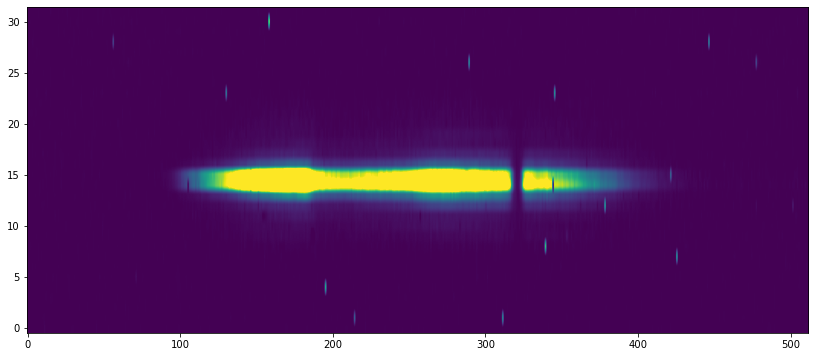

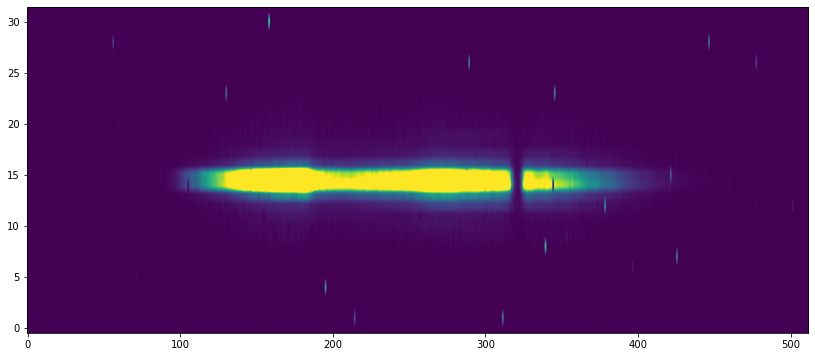

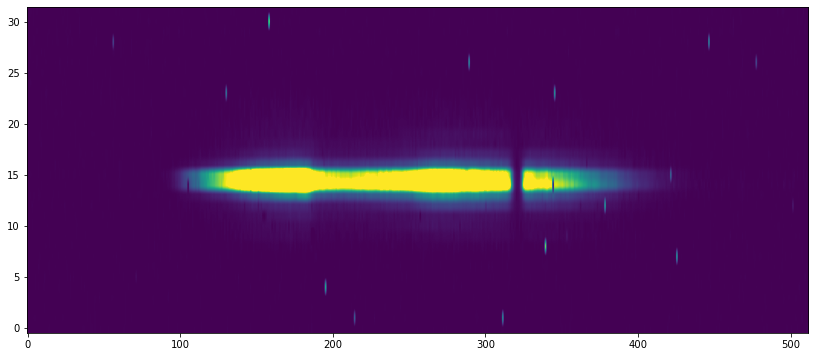

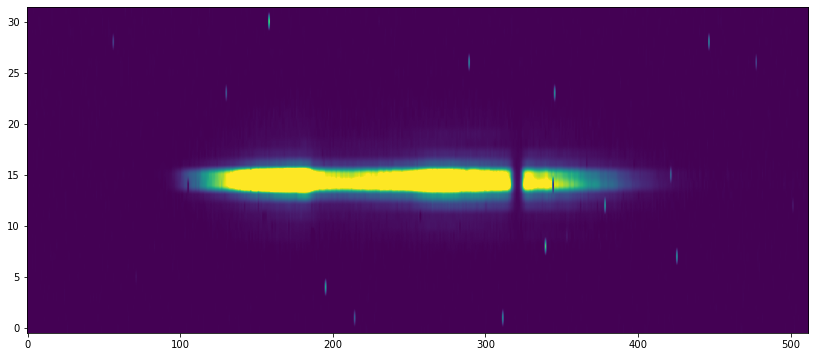

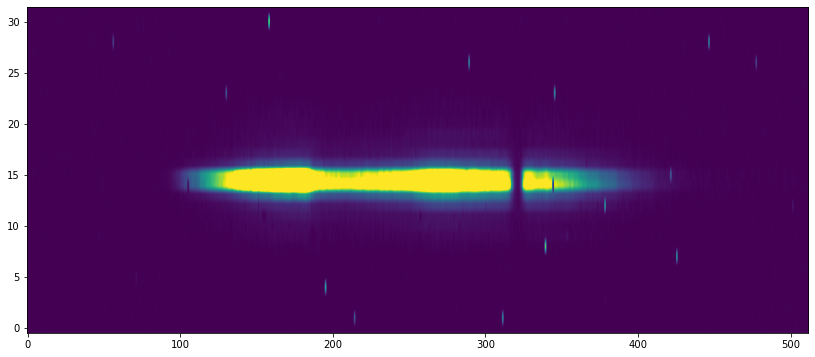

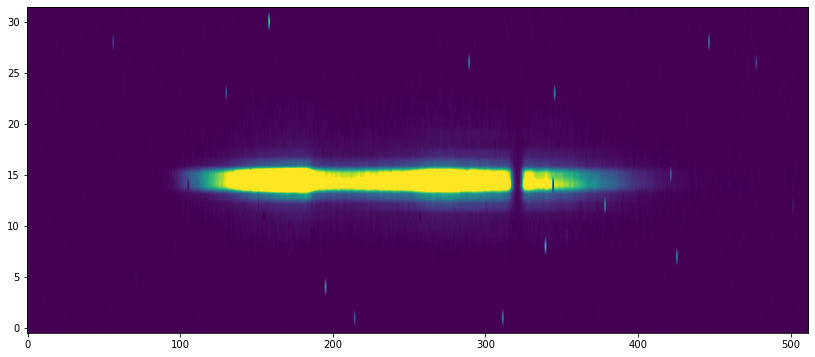

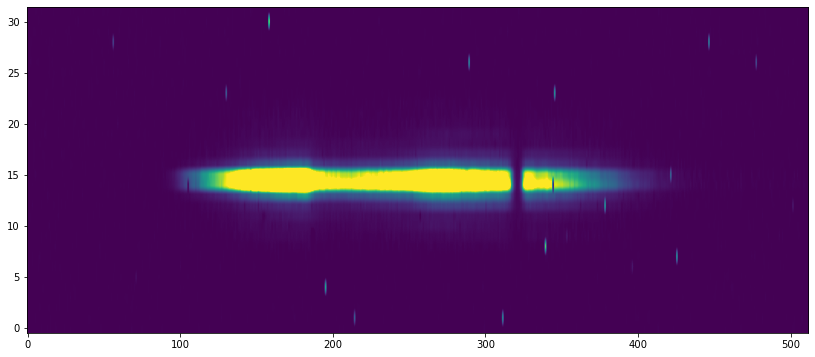

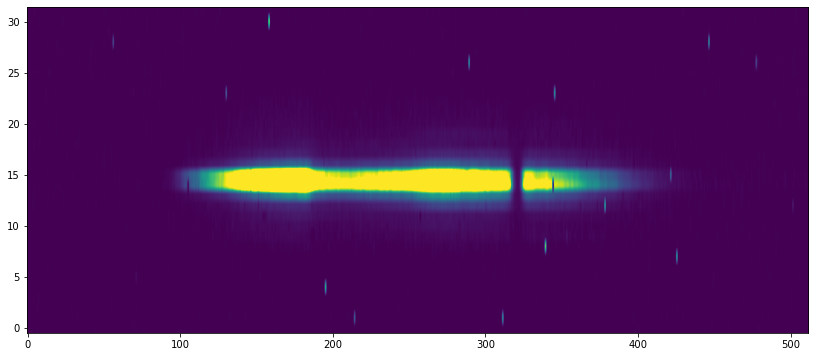

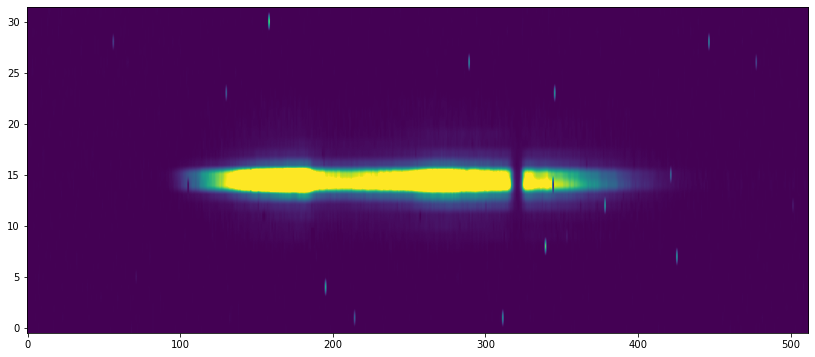

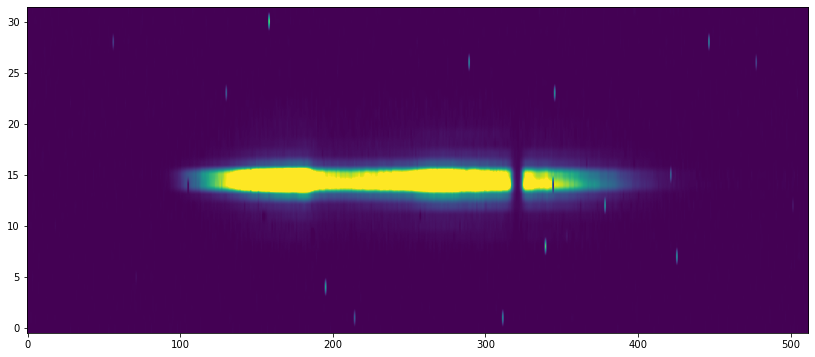

In [55]:
image_corr

%matplotlib inline
for i in range(0, 10):
    print(i)
    fig, ax = plt.subplots(1, 1, figsize=(14, 6))
    plt.imshow(image_corr[i,1,:,:,], origin = 'lower', aspect='auto',  vmin=0, vmax=1e4)

In [194]:
col_values= hdul[1].data[integr_num,group_num,:,col_num]
a_coeff, x = LS_fit_one(time_full[col_num], col_values)

col_values

array([ 76.17236 ,  55.2854  , 110.812256,  51.60547 ,   3.052246,
        -5.154541,  35.532227,  57.990723,  63.292236,  25.965332,
        28.771484,  66.22119 ,  71.372314,  72.36548 ,  14.185303,
        81.569336,  35.612305,  61.165527,  73.97217 ,  10.485352,
        54.402344,  -2.994629,  36.28247 ,  27.429688, -18.005615,
        87.50122 ,  70.29224 ,  69.64526 ,  36.500366, 104.60547 ,
        66.338135,  -3.921875], dtype=float32)

In [220]:
hdul[1].data[integr_num,group_num,:,col_num]

array([ 76.17236 ,  55.2854  , 110.812256,  51.60547 ,   3.052246,
        -5.154541,  35.532227,  57.990723,  63.292236,  25.965332,
        28.771484,  66.22119 ,  71.372314,  72.36548 ,  14.185303,
        81.569336,  35.612305,  61.165527,  73.97217 ,  10.485352,
        54.402344,  -2.994629,  36.28247 ,  27.429688, -18.005615,
        87.50122 ,  70.29224 ,  69.64526 ,  36.500366, 104.60547 ,
        66.338135,  -3.921875], dtype=float32)

In [56]:
hdul[1].data = image_corr

In [77]:
hdul[1].data

array([[[[-1.74647641e+01,  2.56588586e+01, -3.55468958e+00, ...,
           1.07447225e+01,  2.60732685e+01,  1.53745859e+00],
         [ 3.11808297e+01,  4.96964347e+00, -1.85999862e+00, ...,
          -1.01001078e+01,  3.62870460e+00, -1.07950176e+01],
         [ 3.59083326e+01,  6.06942467e+01, -6.51823975e+01, ...,
           4.72340170e+01, -1.70734277e+01, -6.63359738e+00],
         ...,
         [-9.34630526e+00,  5.98266502e+01,  3.64139713e+00, ...,
           3.19332422e+01,  3.05273499e+01,  1.24123716e+01],
         [ 2.29314906e+01,  2.17570640e+01,  4.24402141e+01, ...,
          -2.19021887e+01,  6.21335673e+01, -1.53995358e+01],
         [-2.70055572e+01, -4.83051980e+01, -6.25158518e+01, ...,
          -1.15407202e+01,  6.64685443e+01, -2.47585623e+01]],

        [[-3.25583007e+01,  2.28747677e+01,  3.22371951e+00, ...,
           3.94044095e+01,  2.33857685e+01,  9.18518583e+00],
         [ 1.67075118e+01,  1.18046875e+01,  1.44278730e+00, ...,
           1.22903056e

In [355]:
image_corr

array([[[[-5.10925140e+01,  2.56588586e+01, -3.55468958e+00, ...,
           1.07447225e+01,  2.60732685e+01,  1.53745859e+00],
         [-1.04299878e+00,  4.96964347e+00, -1.85999862e+00, ...,
          -1.01001078e+01,  3.62870460e+00, -1.07950176e+01],
         [ 5.08842567e+00,  6.06942467e+01, -6.51823975e+01, ...,
           4.72340170e+01, -1.70734277e+01, -6.63359738e+00],
         ...,
         [-2.26033118e+00,  5.98266502e+01,  3.64139713e+00, ...,
           3.19332422e+01,  3.05273499e+01,  1.24123716e+01],
         [ 3.14213862e+01,  2.17570640e+01,  4.24402141e+01, ...,
          -2.19021887e+01,  6.21335673e+01, -1.53995358e+01],
         [-1.71117401e+01, -4.83051980e+01, -6.25158518e+01, ...,
          -1.15407202e+01,  6.64685443e+01, -2.47585623e+01]],

        [[-6.60243322e+01,  2.28747677e+01,  3.22371951e+00, ...,
           3.39890408e+01,  2.33857685e+01,  9.18518583e+00],
         [-1.53622803e+01,  1.18046875e+01,  1.44278730e+00, ...,
          -4.11147131e

In [358]:
from astropy.io.fits import getheader
hdr = getheader("dc-roof/jwdata0010010_11010_0001_NRS1_uncal_updatedHDR_10INTS_ramp_STOPAFTERBIAS.fits", 0) 
hdr

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                    8 / array data type                                
NAXIS   =                    0 / number of array dimensions                     
EXTEND  =                    T                                                  
DATE    = '2022-03-21T19:37:31.874' / UTC date file created                     
ORIGIN  = 'STScI   '           / Organization responsible for creating file     
FILENAME= 'jwdata0010010_11010_0001_NRS1_uncal_updatedHDR_10INTS_ramp.fits' / Na
FILETYPE= 'countrate'          / Type of data in the file                       
SDP_VER = 'B7.0    '           / Data processing software version number        
CAL_VER = '1.3.3   '           / Calibration software version number            
CAL_VCS = 'RELEASE '           / Calibration software version control sys number
DATAMODL= 'RampModel'          / Type of data model                             
TELESCOP= 'JWST    '        

In [57]:
write = False # True #

if write:
    hdul.writeto('dc-roof/jwdata0010010_11010_0001_NRS1_uncal_updatedHDR_10INTS_ramp_STOPAFTERBIAS_add_med_corr.fits')